#  Modelling setup

In this notebook we work with the cleaned and feature engineered Metacritic dataset
that was created in the EDA and cleaning notebook.

The main goals of this section are:

1. Load the modelling dataset from disk.
2. Perform sanity checks on the data types and missing values.
3. Define the feature matrix `X` and the target vector `y`.
4. Create a train test split that we can use for different models later on.


#### 0.1 Reproducibility settings
after experiencing different outcomes we found different results after re-running the code. This was a problem, because our explainability became invalid everytime we ran the code again. To ensure consistency, we have set custom seeds in all relevant libraries and functions used in this notebook.


We fix random seeds to make results as stable as possible across reruns.
Note: perfect determinism is not always guaranteed on every machine/backend,
but this will substantially reduce variation.



In [93]:
import os
import random
import numpy as np

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)

random.seed(SEED)
np.random.seed(SEED)

try:
    import tensorflow as tf
    tf.random.set_seed(SEED)

    # Try to enforce deterministic ops (may not be available on every TF version)
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        os.environ["TF_DETERMINISTIC_OPS"] = "1"
except Exception:
    pass

# 1.0 Modelling notebook

In [ ]:

# Load the cleaned and feature-engineered dataset

# %%
import pandas as pd
import numpy as np
from IPython.display import display

df = pd.read_parquet("datasets/computed/metacritic_sales_tier_modelling.parquet")

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

print("\nHead (first 5 rows):")
display(df.head())

print("\nTail (last 5 rows):")
display(df.tail())


Shape: (21770, 75)

Columns:
['movie_id', 'metascore', 'userscore', 'runtime', 'production_budget_log', 'theatre_count_log', 'release_year', 'genre_list', 'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation', 'genre_Biography', 'genre_Black Comedy', 'genre_Comedy', 'genre_Concert/Performance', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Educational', 'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror', 'genre_Multiple Genres', 'genre_Music', 'genre_Musical', 'genre_Mystery', 'genre_News', 'genre_Reality', 'genre_Romance', 'genre_Romantic Comedy', 'genre_Sci-Fi', 'genre_Short', 'genre_Sport', 'genre_Thriller', 'genre_Thriller/Suspense', 'genre_Unknown', 'genre_War', 'genre_Western', 'rating_missing', 'rating_clean', 'rating_G', 'rating_NC-17', 'rating_Not Rated', 'rating_PG', 'rating_PG-13', 'rating_R', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'summer_release', 'holiday_release', 'user_embed_1', 'user_embed_2', 'user_emb

,movie_id,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_list,genre_Action,genre_Adult,...,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10,sales_tier_encoded
0,6305dc82622a,59.0,6.7,129.0,16.993564,4.262680,2000.0,"[""Drama""]",0,0,...,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,0
1,662bc1e3cf57,31.0,8.7,109.0,17.216708,7.797291,2001.0,"[""Drama"",""Thriller""]",0,0,...,-5.644859,6.622465,5.285645,-4.129042,-17.439384,-4.432830,6.081197,-1.913313,3.629471,2
2,dfc233d7a2f9,59.0,6.7,104.0,16.213406,7.788212,2002.0,"[""Drama""]",0,0,...,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,2
3,ed1dd3e75880,41.0,6.4,104.0,16.906553,7.812378,2008.0,"[""Thriller"",""Comedy"",""Romance"",""Crime""]",0,0,...,-6.086373,-7.251342,6.611788,1.355806,1.178939,-1.492724,4.369090,3.527283,1.824804,2
4,8e3d5b8714f4,30.0,5.1,95.0,16.118096,7.589842,2008.0,"[""Fantasy"",""Comedy"",""Romance""]",0,0,...,-4.169212,-3.627316,4.190808,-9.552444,-1.246047,4.286777,-1.451442,5.136322,2.053113,2



Tail (last 5 rows):


,movie_id,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_list,genre_Action,genre_Adult,...,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10,sales_tier_encoded
21765,27e1b584f110,59.0,6.7,168.0,16.993564,4.262680,2021.0,"[""Documentary""]",0,0,...,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,0
21766,fdf6e4d27c7d,50.0,6.2,101.0,16.993564,4.820282,2021.0,"[""Drama""]",0,0,...,9.797144,-8.735904,2.323131,-0.295950,2.524684,4.405437,0.634068,2.040505,-1.448089,1
21767,aa14c9a74a24,59.0,6.7,85.0,16.993564,4.262680,2021.0,"[""Action""]",1,0,...,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,1
21768,9e4d2fe6bc75,59.0,6.7,118.0,16.993564,5.231109,2021.0,"[""Thriller/Suspense""]",0,0,...,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,2
21769,c38d8dba21ac,59.0,6.7,90.0,16.993564,4.262680,2021.0,"[""Adventure""]",0,0,...,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543,2


## 1.1 Sanity check: data types and missing values

Before training any models, we first verify that:

- The target column is present and correctly encoded.
- All feature columns that we will use are numerical.
- Non numerical identifier columns (such as `movie_id`) are not used as features.
- There are no unexpected missing values that could break our models.
- In our current modelling dataset, the missing value check shows 0 missing values for the features we will use, so no additional imputation is required at this stage.

We start by inspecting the data types and by listing which columns are still
of type `object`. These object columns will either be ignored as features or
have already been encoded into numerical dummy variables.


In [55]:
# Inspect data types
print("Data types:")
print(df.dtypes)

# Object type columns (these should not be used directly as features)
print("\nObject type columns:")
print(df.dtypes[df.dtypes == "object"])

# Quick overview of missing values
print("\nMissing values per column (top 20):")
missing_counts = df.isna().sum().sort_values(ascending=False)
display(missing_counts.head(20))


Data types:
movie_id                  object
metascore                float64
userscore                float64
runtime                  float64
production_budget_log    float64
                          ...   
expert_embed_7           float32
expert_embed_8           float32
expert_embed_9           float32
expert_embed_10          float32
sales_tier_encoded         int64
Length: 75, dtype: object

Object type columns:
movie_id        object
genre_list      object
rating_clean    object
dtype: object

Missing values per column (top 20):


movie_id                     0
metascore                    0
userscore                    0
runtime                      0
production_budget_log        0
theatre_count_log            0
release_year                 0
genre_list                   0
genre_Action                 0
genre_Adult                  0
genre_Adventure              0
genre_Animation              0
genre_Biography              0
genre_Black Comedy           0
genre_Comedy                 0
genre_Concert/Performance    0
genre_Crime                  0
genre_Documentary            0
genre_Drama                  0
genre_Educational            0
dtype: int64

### Interpretation of the sanity check

From the data type summary we observe that:

- The target column `sales_tier_encoded` is stored as an integer, which is suitable for a multi class classification task.
- All feature columns that we will actually use are numeric (`int` or `float`), for example:
  `metascore`, `userscore`, `runtime`, `production_budget_log`, `theatre_count_log`,
  the one hot encoded genre and rating columns, and the reduced Transformer embeddings.
- The remaining `object` type columns are:
  - `movie_id` (a pure identifier, not a feature)
  - `genre_list` (original genre string, already encoded into dummy columns)
  - `rating_clean` (human readable rating, already encoded into dummy columns)

These object columns will not be included in the feature matrix `X`.

Regarding missing values:

- We confirm whether there are any remaining NaN values in the numerical features.
  If there are only a few, we will handle them inside a preprocessing pipeline
  (for example with a `SimpleImputer`), or drop the corresponding rows if the amount is negligible.
- The target column `sales_tier_encoded` should not contain missing values. If it does,
  these rows will be removed from the modelling dataset.

Overall, the dataset structure looks suitable for model training, as long as we
explicitly exclude the non numerical identifier and helper columns from `X`.


## 1.2 Define feature matrix `X` and target vector `y`

Next, we build the actual feature matrix `X` and the target vector `y`.

To avoid accidentally using identifiers or raw text as features, we take the
following approach:

1. Select all numerical columns in the dataframe.
2. Remove the target column `sales_tier_encoded` from this list.
3. Use the remaining numerical columns as features.
4. Use `sales_tier_encoded` as the target.

This ensures that `movie_id`, `genre_list`, and `rating_clean` are not used
as input features, and that all features are numeric and ready for modelling.


In [56]:
target = "sales_tier_encoded"

# Select all numerical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns including target:", len(numeric_cols))

# Remove the target from the feature list
feature_cols = [c for c in numeric_cols if c != target]

print("Number of feature columns:", len(feature_cols))
print("First 10 feature columns:", feature_cols[:10])

# Build X and y
X = df[feature_cols].copy()
y = df[target].copy()

print("\nShapes:")
print("X shape:", X.shape)
print("y shape:", y.shape)

# Sanity check: ensure there are no object dtypes in X
print("\nObject dtypes in X (should be empty):")
print(X.dtypes[X.dtypes == "object"])

# Quick look at X and y
print("\nHead of X:")
display(X.head())

print("\nHead of y:")
display(y.head())


Numeric columns including target: 62
Number of feature columns: 61
First 10 feature columns: ['metascore', 'userscore', 'runtime', 'production_budget_log', 'theatre_count_log', 'release_year', 'genre_Action', 'genre_Adult', 'genre_Adventure', 'genre_Animation']

Shapes:
X shape: (21770, 61)
y shape: (21770,)

Object dtypes in X (should be empty):
Series([], dtype: object)

Head of X:


,metascore,userscore,runtime,production_budget_log,theatre_count_log,release_year,genre_Action,genre_Adult,genre_Adventure,genre_Animation,...,expert_embed_1,expert_embed_2,expert_embed_3,expert_embed_4,expert_embed_5,expert_embed_6,expert_embed_7,expert_embed_8,expert_embed_9,expert_embed_10
0,59.0,6.7,129.0,16.993564,4.262680,2000.0,0,0,0,0,...,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
1,31.0,8.7,109.0,17.216708,7.797291,2001.0,0,0,0,0,...,-18.119719,-5.644859,6.622465,5.285645,-4.129042,-17.439384,-4.432830,6.081197,-1.913313,3.629471
2,59.0,6.7,104.0,16.213406,7.788212,2002.0,0,0,0,0,...,5.248415,-0.013454,-0.028619,0.025156,-0.031859,-0.024816,-0.012283,-0.021413,0.034195,-0.025543
3,41.0,6.4,104.0,16.906553,7.812378,2008.0,0,0,0,0,...,-19.683950,-6.086373,-7.251342,6.611788,1.355806,1.178939,-1.492724,4.369090,3.527283,1.824804
4,30.0,5.1,95.0,16.118096,7.589842,2008.0,0,0,0,0,...,-22.277643,-4.169212,-3.627316,4.190808,-9.552444,-1.246047,4.286777,-1.451442,5.136322,2.053113



Head of y:


0    0
1    2
2    2
3    2
4    2
Name: sales_tier_encoded, dtype: int64

### Interpretation of the feature matrix and target vector

The shapes of `X` and `y` confirm that:

- `X` contains one row per movie and a large set of numerical features
  (metadata, engineered calendar variables, genre and rating dummies,
  and Transformer embedding components).
- `y` is a one dimensional vector with the encoded sales tier
  (`0 = Low`, `1 = Medium`, `2 = High`).

The final check for object dtypes in `X` is empty, which means that all features
are numerical. This is exactly what we need for both classical machine learning
models and neural networks.

We are now ready to split the data into a training and test set.
This will allow us to evaluate our models on unseen data.


## 1.3 Train test split

To evaluate our models fairly, we split the dataset into a training set and a test set.

We use a stratified split on `sales_tier_encoded` so that the class distribution
(Low, Medium, High) is approximately the same in both the training and test sets.

The test set will be used only for final evaluation. All model training and tuning
will be performed on the training set (optionally with cross validation).


In [57]:
from sklearn.model_selection import train_test_split

# Perform a stratified train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

print("\nClass distribution in full data:")
print(y.value_counts(normalize=True).sort_index())

print("\nClass distribution in train set:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True).sort_index())


Train set shape: (17416, 61)
Test set shape: (4354, 61)

Class distribution in full data:
sales_tier_encoded
0    0.329995
1    0.340009
2    0.329995
Name: proportion, dtype: float64

Class distribution in train set:
sales_tier_encoded
0    0.329984
1    0.340032
2    0.329984
Name: proportion, dtype: float64

Class distribution in test set:
sales_tier_encoded
0    0.330041
1    0.339917
2    0.330041
Name: proportion, dtype: float64


### Interpretation of the train test split

The shapes show that:

- The training set contains 80 percent of the movies.
- The test set contains the remaining 20 percent.

The class distributions in the full dataset, the training set, and the test set
are very similar, which means that the stratified split worked as intended.
All three sales tiers (Low, Medium, High) are represented in both sets.
(encoded as 0 = Low, 1 = Medium, 2 = High)

From this point onwards we can start training baseline models such as:

- A dummy classifier (predicting the most frequent class).
- A logistic regression model using only structured features.
- A model that also includes the Transformer based text embeddings.

These models will allow us to quantify how much predictive power we gain
from the different types of features in our dataset.


## 4. Baseline models

Now that we have a cleaned modelling dataset and a stratified train–test split,  
we can start with a few simple baseline models.

The goal of this section is to:

1. Establish a very naive baseline using a **dummy classifier**  
2. Train a **logistic regression model** on the structured features only  
3. Train a **logistic regression model including the Transformer embeddings**  
4. Compare the performance of these baselines in terms of accuracy and macro F1

The idea is the same structure as in the course modelling notebook:

- Prepare the data  
- Train a simple baseline model  
- Gradually increase model complexity and feature richness  
- Evaluate and compare on the held-out test set


### 4.1 Dummy classifier (most frequent class)

We start with the simplest possible classifier in `sklearn`:  
the `DummyClassifier` with strategy `"most_frequent"`.

This model completely ignores all input features and always predicts the class  
that is most common in the training data. It is intentionally stupid, but very useful:

- It gives a **reference level** of performance that any serious model should beat  
- It helps us see whether our target is strongly imbalanced or roughly balanced  
- It makes the evaluation pipeline (metrics, reports) clear on a trivial model


In [58]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

# dummy baseline: always predict the most frequent class
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

y_hat_dummy = dummy_clf.predict(X_test)

print("=== Dummy classifier (most frequent class) ===")
print("Accuracy:", round(accuracy_score(y_test, y_hat_dummy), 3))
print("Macro F1:", round(f1_score(y_test, y_hat_dummy, average="macro"), 3))
print("\nClassification report:")
print(classification_report(y_test, y_hat_dummy))


=== Dummy classifier (most frequent class) ===
Accuracy: 0.34
Macro F1: 0.169

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1437
           1       0.34      1.00      0.51      1480
           2       0.00      0.00      0.00      1437

    accuracy                           0.34      4354
   macro avg       0.11      0.33      0.17      4354
weighted avg       0.12      0.34      0.17      4354



c:\Users\jeffr\Documents\AI methods\project\bjj\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jeffr\Documents\AI methods\project\bjj\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\jeffr\Documents\AI methods\project\bjj\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

#### Interpretation of the dummy baseline

The dummy classifier with `strategy="most_frequent"` always predicts a single class.
In our case it always predicts **class 1** (the most frequent sales tier in the training set).

From the results:

- **Accuracy ≈ 0.34**  
  This is almost exactly the proportion of class 1 in the test set  
  (support: 1480 out of 4354 observations). The model “works” only because it
  keeps guessing the majority class.

- **Class-wise performance**
  - Class **1** has precision 0.34, recall 1.00 and F1 ≈ 0.51, because every
    observation is predicted as class 1.
  - Classes **0** and **2** are never predicted at all (recall = 0), so their
    precision and F1 are 0. This also explains the `UndefinedMetricWarning`:
    precision is ill-defined when there are no predicted samples for a class.

- **Macro F1 ≈ 0.17**  
  Macro F1 averages the F1 over all three classes. Since two out of three
  classes have F1 = 0, the macro F1 is very low, even though accuracy is 0.34.

- **Weighted avg F1 ≈ 0.17**  
  The weighted F1 is also low, because the model completely ignores two thirds
  of the classes.

This confirms that the dummy classifier is a very weak baseline:  
it only tells us “what happens if we always predict the majority class”.
Any useful model should clearly beat:

- **Accuracy ≈ 0.34**, and  
- **Macro F1 ≈ 0.17**


### 4.2 Logistic regression with structured features only

As a first real model we train a **multinomial logistic regression** on the structured
(tabular) features.

In this step we only use:

- Numeric features such as:  
  `metascore`, `userscore`, `runtime`, `production_budget_log`,  
  `theatre_count_log`, `release_year` (if available in the dataset)
- One-hot encoded genres: all columns starting with `genre_`
- One-hot encoded ratings: all columns starting with `rating_`
- Seasonality indicators: all columns starting with `season_`, plus  
  `summer_release` and `holiday_release` if they exist

We deliberately **exclude** the Transformer-based text embeddings here, so that we can see how
far we get using traditional tabular information alone.

Because logistic regression is sensitive to feature scaling, we wrap it in a `Pipeline`
together with a `StandardScaler`:

- `StandardScaler` standardises each feature (zero mean, unit variance)
- Logistic regression then operates in a numerically stable range


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Build feature groups based on the columns that are actually present in X_train
available_cols = X_train.columns

# Numeric features we would like to use (only if present)
numeric_features = [
    c
    for c in [
        "metascore",
        "userscore",
        "runtime",
        "production_budget_log",
        "theatre_count_log",
        "release_year",
    ]
    if c in available_cols
]

# One-hot encoded genres
genre_features = [c for c in available_cols if c.startswith("genre_")]

# One-hot encoded ratings
rating_features = [c for c in available_cols if c.startswith("rating_")]

# Seasonality features (only if present in X_train)
season_features = [c for c in available_cols if c.startswith("season_")]
for extra in ["summer_release", "holiday_release"]:
    if extra in available_cols:
        season_features.append(extra)

structured_features = (
    numeric_features
    + genre_features
    + rating_features
    + season_features
)

print("Numeric features:", numeric_features)
print("Number of genre features:", len(genre_features))
print("Number of rating features:", len(rating_features))
print("Number of season features:", len(season_features))
print("Total structured features:", len(structured_features))

# Sanity check: everything in structured_features must be in X_train
missing_in_X = [c for c in structured_features if c not in available_cols]
print("Features listed but not in X_train (should be empty):", missing_in_X)

# Build pipeline: scale -> logistic regression
log_reg_structured = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                max_iter=500,  # enough iterations so it converges
            ),
        ),
    ]
)

# Fit on train set (structured features only)
log_reg_structured.fit(X_train[structured_features], y_train)

# Evaluate on test set
y_hat_structured = log_reg_structured.predict(X_test[structured_features])

print("=== Logistic regression (structured features only) ===")
print("Accuracy:", round(accuracy_score(y_test, y_hat_structured), 3))
macro_f1_structured = f1_score(y_test, y_hat_structured, average="macro")
print("Macro F1:", round(macro_f1_structured, 3))
print("\nClassification report:")
print(classification_report(y_test, y_hat_structured))


Numeric features: ['metascore', 'userscore', 'runtime', 'production_budget_log', 'theatre_count_log', 'release_year']
Number of genre features: 32
Number of rating features: 1
Number of season features: 2
Total structured features: 41
Features listed but not in X_train (should be empty): []
=== Logistic regression (structured features only) ===
Accuracy: 0.566
Macro F1: 0.569

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.64      0.59      1437
           1       0.47      0.47      0.47      1480
           2       0.72      0.60      0.65      1437

    accuracy                           0.57      4354
   macro avg       0.58      0.57      0.57      4354
weighted avg       0.58      0.57      0.57      4354



#### Interpretation of the structured logistic regression

Compared to the dummy classifier (Accuracy ≈ 0.34, Macro F1 ≈ 0.17),  
the logistic regression with structured features performs **substantially better**:

- **Accuracy ≈ 0.57**  
  The model correctly predicts the sales tier for about 57% of the movies,
  which is a clear improvement over always guessing the majority class.

- **Macro F1 ≈ 0.57**  
  This is more than three times higher than the dummy baseline (≈ 0.17),
  which shows that the model is learning to handle all three classes instead
  of collapsing onto a single tier.

- **Per-class performance**
  - Class **0 (Low)**: F1 ≈ 0.59 (precision 0.54, recall 0.64)  
    The model distinguishes low-tier movies reasonably well.
  - Class **1 (Medium)**: F1 ≈ 0.47  
    This is the hardest class: many medium-tier movies are confused with
    low or high tier.
  - Class **2 (High)**: F1 ≈ 0.65 (precision 0.72, recall 0.60)  
    High-performing movies are recognised relatively well, which makes sense
    given that large budgets, high theatre counts and certain genres are
    quite characteristic for big box office hits.

Overall, this shows that **structured features alone** (scores, budget, runtime,
genre, rating, release timing) already contain a meaningful amount of signal
about the sales tier, but the medium tier remains difficult to separate cleanly
from the low and high tiers.


### 4.3 Logistic regression with structured features and Transformer embeddings

We now extend the feature set with the **review embeddings** that we extracted
from the user and expert review texts.

Concretely, we add:

- `user_embed_1` to `user_embed_10`
- `expert_embed_1` to `expert_embed_10`

These 20 continuous features summarise the semantic content of reviews in a
low-dimensional vector space. By combining them with the structured features,
the model has access to:

- Information about the movie itself (budget, genre, rating, timing)
- Information about how audiences and critics talk about the movie (text embeddings)

We re-use the same pipeline structure (`StandardScaler` + `LogisticRegression`),
but now with an extended feature set.


In [60]:
# Re-use available_cols and structured_features from the previous cell
available_cols = X_train.columns

# Embedding features: user + expert review embeddings
embedding_features = [
    c
    for c in available_cols
    if c.startswith("user_embed_") or c.startswith("expert_embed_")
]

print("Number of embedding features:", len(embedding_features))

all_features = structured_features + embedding_features
print("Total number of features (structured + embeddings):", len(all_features))

# Sanity check: all all_features should be in X_train
missing_in_X_all = [c for c in all_features if c not in available_cols]
print("Features listed but not in X_train (should be empty):", missing_in_X_all)

log_reg_full = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                max_iter=500,
            ),
        ),
    ]
)

# Fit model on train set using all features (structured + embeddings)
log_reg_full.fit(X_train[all_features], y_train)

# Evaluate on test set
y_hat_full = log_reg_full.predict(X_test[all_features])

print("=== Logistic regression (structured + embeddings) ===")
print("Accuracy:", round(accuracy_score(y_test, y_hat_full), 3))
macro_f1_full = f1_score(y_test, y_hat_full, average="macro")
print("Macro F1:", round(macro_f1_full, 3))
print("\nClassification report:")
print(classification_report(y_test, y_hat_full))


Number of embedding features: 20
Total number of features (structured + embeddings): 61
Features listed but not in X_train (should be empty): []
=== Logistic regression (structured + embeddings) ===
Accuracy: 0.571
Macro F1: 0.574

Classification report:
              precision    recall  f1-score   support

           0       0.54      0.65      0.59      1437
           1       0.47      0.47      0.47      1480
           2       0.74      0.60      0.66      1437

    accuracy                           0.57      4354
   macro avg       0.58      0.57      0.57      4354
weighted avg       0.58      0.57      0.57      4354



#### Interpretation: impact of the embeddings

When we add the Transformer-based review embeddings on top of the structured features,
the performance improves slightly:

- **Accuracy:** from ≈ 0.566 → ≈ 0.571  
- **Macro F1:** from ≈ 0.569 → ≈ 0.574

So the gain is **modest but consistent**: both metrics move in the right direction.

Looking at the class-wise F1-scores:

- Class **0 (Low)**: F1 stays around ≈ 0.59, with a small increase in recall  
  (from 0.64 to 0.65), so low-tier movies are recognised just as well.
- Class **1 (Medium)**: F1 remains ≈ 0.47  
  The medium tier is still the most challenging class: the embeddings do not
  dramatically change its performance.
- Class **2 (High)**: F1 improves slightly from ≈ 0.65 to ≈ 0.66  
  Here the embeddings seem to help a bit in distinguishing high-tier movies
  from the others, which is plausible: the language in highly positive or
  enthusiastic reviews may carry additional signal for blockbusters.

In summary:

- Moving from the structured-only model to the **structured + embeddings** model
  yields a **small but positive** performance gain.
- This suggests that review text does contain extra information that is not fully
  captured by the tabular metadata, but:
  - the effect is not huge, and
  - a linear model like logistic regression might not be powerful enough to fully
    exploit the high-dimensional embedding space.

A natural next step would be to try a more flexible model (e.g. Random Forest,
Gradient Boosting, or a small neural network) on the same feature set, to see
whether a non-linear classifier can extract more value from the combination of
structured data and text embeddings, especially for the difficult medium tier.


### 4.4 Visual evaluation: confusion matrices

Numerical metrics such as accuracy and macro F1 are useful, but they do not show
*where* the models make mistakes.

To better understand the behaviour of our classifiers, we plot the confusion
matrices for:

1. The dummy classifier (most frequent class)  
2. Logistic regression with structured features only  
3. Logistic regression with structured features + embeddings

This helps us see, for example:

- Which sales tiers are often confused with each other
- Whether a model systematically overpredicts a specific class
- How the error patterns change when we add more information (embeddings)


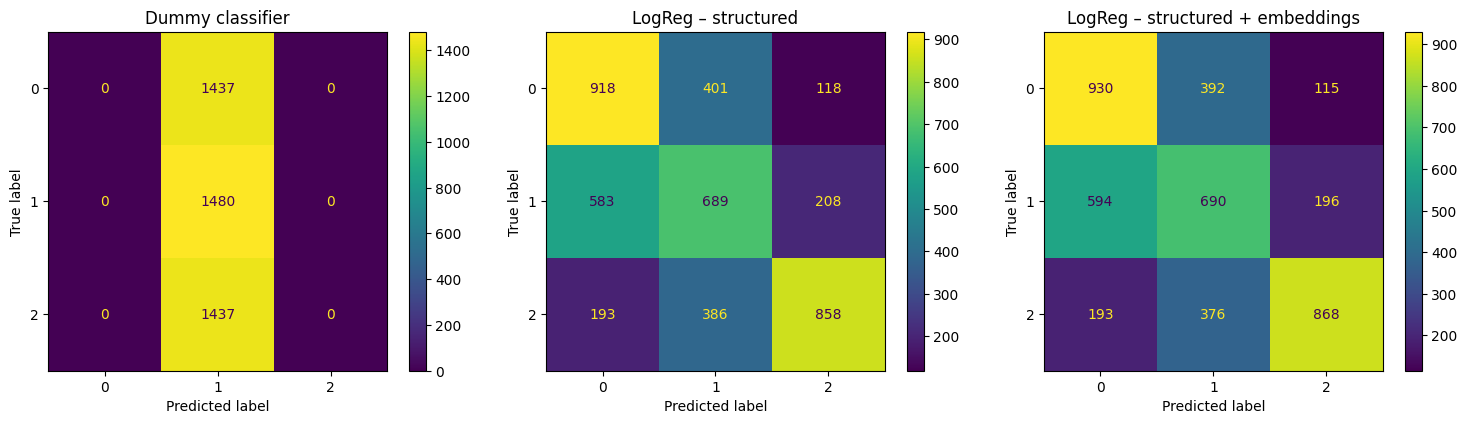

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Make sure we have the predictions available:
# y_hat_dummy        from section 4.1
# y_hat_structured   from section 4.2
# y_hat_full         from section 4.3

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Dummy classifier
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_hat_dummy,
    display_labels=[0, 1, 2],
    ax=axes[0]
)
axes[0].set_title("Dummy classifier")

# 2. Logistic regression (structured)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_hat_structured,
    display_labels=[0, 1, 2],
    ax=axes[1]
)
axes[1].set_title("LogReg – structured")

# 3. Logistic regression (structured + embeddings)
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_hat_full,
    display_labels=[0, 1, 2],
    ax=axes[2]
)
axes[2].set_title("LogReg – structured + embeddings")

plt.tight_layout()
plt.show()


#### Interpretation of the confusion matrices

The three confusion matrices clearly show how each model behaves.

- **Dummy classifier**

  - All movies are predicted as class 1 (the majority class), which explains why
    the entire middle column is filled and the other columns are empty.
  - True classes 0 and 2 are never predicted at all. This matches the poor macro
    F1 of about 0.17 that we saw before.

- **LogReg – structured**

  - For **class 0 (Low)**, 918 out of 1437 movies are correctly classified
    (top left cell). The remaining movies are mostly pushed into class 1.
  - For **class 1 (Medium)**, the mass is spread across all three predicted
    classes: 689 correctly predicted, but 583 misclassified as 0 and 208 as 2.
    This confirms that the medium tier is the hardest to separate.
  - For **class 2 (High)**, 858 out of 1437 movies are correctly identified.
    The main confusion is with class 1, which is reasonable, because high tier
    movies often look similar to solid medium performers in terms of features.
  - Overall the diagonal is clearly dominant, which explains the macro F1
    around 0.57.

- **LogReg – structured + embeddings**

  - The pattern is very similar to the structured-only model, but there are a
    few visible improvements.
  - For **class 0**, slightly more true low tier movies move from the 1 column
    to the 0 column (930 instead of 918 correct).
  - For **class 1**, the confusion structure remains almost the same, which is
    consistent with the stable F1 for this class.
  - For **class 2**, the number of correctly classified high tier movies increases
    from 858 to 868 and the misclassifications into class 1 drop from 386 to 376.
    This is where the embeddings seem to help the most.
  - The diagonal is a bit cleaner overall, which is in line with the small gain
    in accuracy and macro F1.

In short, the matrices show a big qualitative jump from the dummy model to the
structured logistic regression, and a smaller but visible improvement when
embeddings are added, especially for the high sales tier (class 2).


### 4.5 Visual comparison of model performance 

To summarise the performance of the three models, we can also plot a simple
bar chart comparing their accuracy and macro F1.

This gives a quick overview of how much we gain when moving from:

- The dummy classifier  
- To logistic regression with structured features  
- To logistic regression with structured features + embeddings


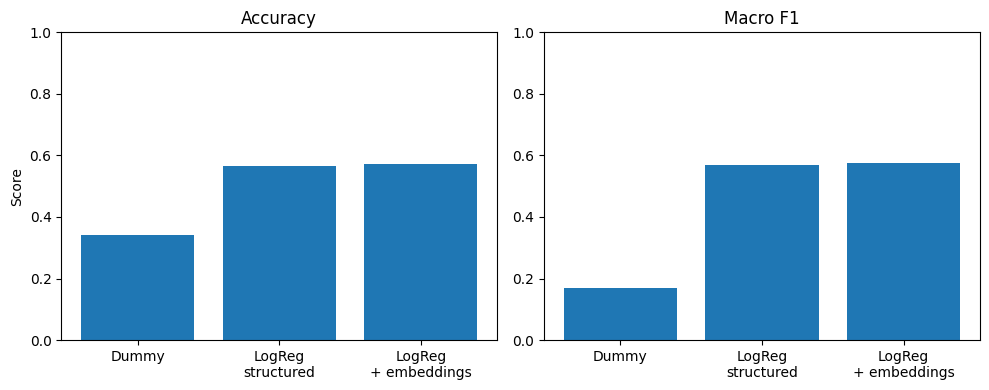

Accuracies: [0.34, 0.566, 0.571]
Macro F1: [0.169, 0.569, 0.574]


In [62]:
# Recompute metrics here to ensure we have them available
acc_dummy = accuracy_score(y_test, y_hat_dummy)
macro_f1_dummy = f1_score(y_test, y_hat_dummy, average="macro")

acc_structured = accuracy_score(y_test, y_hat_structured)
macro_f1_structured = f1_score(y_test, y_hat_structured, average="macro")

acc_full = accuracy_score(y_test, y_hat_full)
macro_f1_full = f1_score(y_test, y_hat_full, average="macro")

models = ["Dummy", "LogReg\nstructured", "LogReg\n+ embeddings"]
accuracies = [acc_dummy, acc_structured, acc_full]
macro_f1s = [macro_f1_dummy, macro_f1_structured, macro_f1_full]

x = range(len(models))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# Accuracy plot
axes[0].bar(x, accuracies)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylim(0, 1)
axes[0].set_title("Accuracy")
axes[0].set_ylabel("Score")

# Macro F1 plot
axes[1].bar(x, macro_f1s)
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylim(0, 1)
axes[1].set_title("Macro F1")

plt.tight_layout()
plt.show()

print("Accuracies:", [round(a, 3) for a in accuracies])
print("Macro F1:", [round(f, 3) for f in macro_f1s])


#### Interpretation of the metric comparison

The bar charts summarise the performance of the three models in terms of
accuracy and macro F1:

- **Dummy classifier**
  - Accuracy ≈ **0.34**
  - Macro F1 ≈ **0.17**
  - This corresponds to the performance of always predicting the majority class
    and effectively ignoring two out of the three tiers.

- **LogReg – structured**
  - Accuracy increases to ≈ **0.566**
  - Macro F1 increases to ≈ **0.569**
  - This is a large improvement compared to the dummy baseline.  
    The model is clearly using information from the structured features
    (budget, theatre count, scores, genre, rating, release timing) to
    distinguish between the three sales tiers.

- **LogReg – structured + embeddings**
  - Accuracy increases slightly further to ≈ **0.571**
  - Macro F1 increases slightly to ≈ **0.574**
  - The gain relative to the structured-only model is small but positive.
    The embeddings add some extra information, but the effect is limited,
    probably because logistic regression is a linear model and cannot fully
    exploit the high-dimensional embedding space.

In summary:

- The step from the **dummy classifier** to **logistic regression with structured
  features** yields a large performance improvement, showing that the tabular
  information already contains a lot of signal about the final box office tier.
- Adding the **embeddings** provides a small, consistent additional gain,
  especially visible in the confusion matrix for the high tier, but it does not
  dramatically change the overall performance level.
- There is still room for more powerful non-linear models to see whether they
  can extract more value from the embeddings, in particular for the difficult
  medium tier (class 1).


## 5. Non-linear models

So far, we have only used linear models (logistic regression).
In this section we explore more flexible non-linear classifiers and check
whether they can extract additional signal from our features.

We focus on two models:

1. **k-Nearest Neighbours (KNN)** – a distance-based classifier
2. **Support Vector Machine (SVM)** with an RBF kernel – a margin-based non-linear classifier

Both models are trained on the same train–test split as before and evaluated
using **accuracy** and **macro F1** on the held-out test set.
We use the full feature set (structured features + embeddings) to give
these models as much information as possible.


### 5.1 k-Nearest Neighbours (KNN) with validation-based tuning

The KNN classifier predicts the class of a movie by looking at the labels of
its *k* nearest neighbours in feature space.

- It can model non-linear decision boundaries.
- Performance strongly depends on the choice of:
  - the number of neighbours `k`
  - the distance metric (e.g. Euclidean vs cosine distance)

Here we:

1. Create a **validation split** inside the training set.
2. Try a small grid of `(k, metric)` combinations.
3. Select the model with the highest **macro F1** on the validation set.
4. Retrain the best KNN on the full training set and evaluate it on the test set.


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# Use the full feature set (structured + embeddings)
X_train_full = X_train[all_features].copy()
X_test_full = X_test[all_features].copy()

print("X_train_full shape:", X_train_full.shape)
print("X_test_full shape:", X_test_full.shape)

# ---------------------------------
# 1) Inner train/validation split
# ---------------------------------
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(
    X_train_full,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

print("KNN inner train shape:", X_train_knn.shape)
print("KNN validation shape:", X_val_knn.shape)

# ---------------------------------
# 2) Extended grid over k and metric
# ---------------------------------
# More k values to obtain a smoother curve (odd numbers from 3 to 39)
k_values = list(range(3, 40, 2))
metrics = ["minkowski", "cosine"]

results = []
best_f1 = -np.inf
best_params = None

for k in k_values:
    for metric in metrics:
        knn = KNeighborsClassifier(
            n_neighbors=k,
            metric=metric,
            algorithm="brute",
        )
        knn.fit(X_train_knn, y_train_knn)
        y_val_pred = knn.predict(X_val_knn)

        acc = accuracy_score(y_val_knn, y_val_pred)
        f1 = f1_score(y_val_knn, y_val_pred, average="macro")

        print(f"k={k:2d}, metric={metric:9s} -> val acc={acc:.3f}, macro F1={f1:.3f}")

        results.append(
            {
                "k": k,
                "metric": metric,
                "val_acc": acc,
                "val_f1": f1,
            }
        )

        if f1 > best_f1:
            best_f1 = f1
            best_params = {"k": k, "metric": metric}

print("\nBest KNN params on validation set:", best_params)
print("Best validation macro F1:", round(best_f1, 3))

# ---------------------------------
# 3) Train best KNN on full training set & evaluate on test set
# ---------------------------------
best_knn = KNeighborsClassifier(
    n_neighbors=best_params["k"],
    metric=best_params["metric"],
    algorithm="brute",
)

best_knn.fit(X_train_full, y_train)
y_hat_knn = best_knn.predict(X_test_full)

print("\n=== KNN (best params on validation set) ===")
print("Accuracy:", round(accuracy_score(y_test, y_hat_knn), 3))
print("Macro F1:", round(f1_score(y_test, y_hat_knn, average='macro'), 3))

print("\nClassification report:")
print(classification_report(y_test, y_hat_knn))


X_train_full shape: (17416, 61)
X_test_full shape: (4354, 61)
KNN inner train shape: (13932, 61)
KNN validation shape: (3484, 61)
k= 3, metric=minkowski -> val acc=0.533, macro F1=0.532
k= 3, metric=cosine    -> val acc=0.512, macro F1=0.512
k= 5, metric=minkowski -> val acc=0.532, macro F1=0.535
k= 5, metric=cosine    -> val acc=0.535, macro F1=0.536
k= 7, metric=minkowski -> val acc=0.542, macro F1=0.545
k= 7, metric=cosine    -> val acc=0.542, macro F1=0.544
k= 9, metric=minkowski -> val acc=0.551, macro F1=0.553
k= 9, metric=cosine    -> val acc=0.546, macro F1=0.547
k=11, metric=minkowski -> val acc=0.549, macro F1=0.552
k=11, metric=cosine    -> val acc=0.546, macro F1=0.547
k=13, metric=minkowski -> val acc=0.548, macro F1=0.551
k=13, metric=cosine    -> val acc=0.550, macro F1=0.550
k=15, metric=minkowski -> val acc=0.549, macro F1=0.552
k=15, metric=cosine    -> val acc=0.544, macro F1=0.546
k=17, metric=minkowski -> val acc=0.552, macro F1=0.554
k=17, metric=cosine    -> val 

#### Interpretation of the KNN results

The tuned KNN model gives us a first non-linear benchmark.

On the validation set, the best configuration was:

- **k = 27**, **metric = minkowski** (Euclidean distance)
- Validation macro F1 ≈ **0.563**

On the test set, this best KNN model achieves:

- **Accuracy ≈ 0.558**
- **Macro F1 ≈ 0.562**

This is clearly much better than the dummy classifier (Accuracy ≈ 0.34, Macro F1 ≈ 0.17),
but still slightly below the logistic regression with structured + embedding features
(Accuracy ≈ 0.571, Macro F1 ≈ 0.574).

Looking at the per-class F1 scores:

- **Class 0 (Low)**: F1 ≈ **0.57** (precision 0.52, recall 0.63)  
  Low-sales movies are recognised reasonably well, although a sizeable fraction
  is still confused with the medium tier.
- **Class 1 (Medium)**: F1 ≈ **0.45** (precision 0.45, recall 0.44)  
  This remains the most challenging class, with many medium-tier movies being
  classified as either low or high.
- **Class 2 (High)**: F1 ≈ **0.67** (precision 0.76, recall 0.61)  
  High-sales movies are detected quite well, similar to the logistic regression
  models.

In summary:

- KNN confirms that a non-linear, distance-based method can reach a performance
  level comparable to the linear logistic regression baseline, but it **does not
  outperform** the best logistic regression model with embeddings.
- The medium tier (class 1) remains the hardest to classify correctly, which
  suggests that the decision boundaries between medium and the other tiers are
  inherently fuzzy in this feature space.


#### 5.1.1 Visualising KNN validation performance

To better understand how the choice of `k` and the distance metric affects the
KNN model, we plot the validation macro F1 score against `k` for both metrics
(`minkowski` and `cosine`).

This helps us see:

- whether performance stabilises after a certain value of `k`,
- and which distance metric tends to work better on this dataset.


,k,metric,val_acc,val_f1
0,3,minkowski,0.532721,0.532458
1,3,cosine,0.512342,0.511679
2,5,minkowski,0.531860,0.535179
3,5,cosine,0.535017,0.536351
4,7,minkowski,0.542480,0.544777


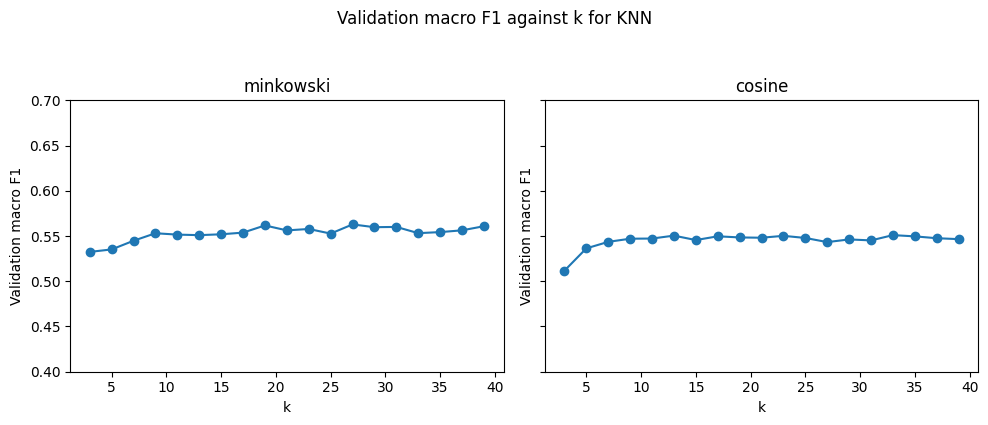

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the KNN tuning results into a DataFrame
knn_results_df = pd.DataFrame(results)
display(knn_results_df.head())

# Create the plot: F1 against k for each metric
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

metrics_unique = knn_results_df["metric"].unique()

for ax, metric in zip(axes, metrics_unique):
    subset = knn_results_df[knn_results_df["metric"] == metric].sort_values("k")
    ax.plot(subset["k"], subset["val_f1"], marker="o")
    ax.set_title(metric)
    ax.set_xlabel("k")
    ax.set_ylabel("Validation macro F1")
    ax.set_ylim(0.4, 0.7)

fig.suptitle("Validation macro F1 against k for KNN", y=1.05)
plt.tight_layout()
plt.show()


#### Interpretation of the KNN tuning plot

From the KNN tuning plot we can see that:

- For the **minkowski** (Euclidean) metric, the validation macro F1 increases
  quickly when moving from very small `k` values to around **k ≈ 15–20**, and
  then fluctuates slightly but stays in a relatively narrow band.
- Performance is highest in the region **k ≈ 25–30**; the best configuration
  found by the grid search is **k = 27**, which lies right in this plateau.
- For the **cosine** metric, the same pattern appears, but the whole curve is
  consistently **slightly below** the minkowski curve. Cosine distance never
  clearly overtakes Euclidean distance on this dataset.
- Very small `k` values (e.g. 3 or 5) have noticeably lower F1 scores, which
  fits the intuition that KNN becomes more sensitive to noise when only a few
  neighbours are considered.

Overall, the plot confirms that:

- Choosing a **larger neighbourhood** (around 20–30 neighbours) stabilises
  performance in this high-dimensional feature space.
- The **minkowski** metric is the better choice here, and our selected
  hyperparameters (`k = 27`, `metric = minkowski`) are in a sensible region of
  the validation landscape rather than being an isolated lucky guess.


### 5.2 Support Vector Machine (SVM) with RBF kernel

A Support Vector Machine with an RBF (Gaussian) kernel is a powerful
non-linear classifier. It projects the data into a higher-dimensional
space and finds a separating margin there.

Key hyperparameters:

- `C`: controls how strongly the model penalises misclassifications
  (large `C` = less regularisation).
- `gamma`: controls the width of the RBF kernel
  (large `gamma` = very local decision boundaries).

We use a **pipeline** with:

1. `StandardScaler` to normalise all features.
2. `SVC` with an RBF kernel.

Hyperparameters are tuned with `GridSearchCV` using **macro F1** as the
scoring metric and a 3-fold stratified cross-validation on the training set.


In [65]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Re-use X_train_full and X_test_full from the KNN section

svc_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", random_state=42)),
    ]
)

param_grid = {
    "svc__C": [0.1, 1.0, 10.0],
    "svc__gamma": [0.01, 0.1, 1.0],
}

grid_svc = GridSearchCV(
    estimator=svc_pipeline,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=2,
)

grid_svc.fit(X_train_full, y_train)

print("Best SVM parameters:", grid_svc.best_params_)
print("Best CV macro F1:", round(grid_svc.best_score_, 3))

# Evaluate the best model on the test set
svc_best = grid_svc.best_estimator_
y_hat_svm = svc_best.predict(X_test_full)

print("\n=== SVM (RBF kernel, tuned with GridSearchCV) ===")
print("Accuracy:", round(accuracy_score(y_test, y_hat_svm), 3))
print("Macro F1:", round(f1_score(y_test, y_hat_svm, average='macro'), 3))

print("\nClassification report:")
print(classification_report(y_test, y_hat_svm))


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best SVM parameters: {'svc__C': 1.0, 'svc__gamma': 0.01}
Best CV macro F1: 0.568

=== SVM (RBF kernel, tuned with GridSearchCV) ===
Accuracy: 0.563
Macro F1: 0.566

Classification report:
              precision    recall  f1-score   support

           0       0.52      0.64      0.57      1437
           1       0.48      0.48      0.48      1480
           2       0.75      0.57      0.65      1437

    accuracy                           0.56      4354
   macro avg       0.58      0.56      0.57      4354
weighted avg       0.58      0.56      0.57      4354



#### Interpretation of the SVM results

The SVM with RBF kernel is another powerful non-linear model.

The grid search over `C` and `gamma` selected:

- **C = 1.0**, **gamma = 0.01**
- Best cross-validated macro F1 ≈ **0.568**

Evaluated on the held-out test set, the tuned SVM achieves:

- **Accuracy ≈ 0.563**
- **Macro F1 ≈ 0.566**

This places the SVM:

- Clearly **above the dummy classifier** (Accuracy ≈ 0.34, Macro F1 ≈ 0.17)
- Roughly **on par with the logistic regression** models and the KNN model  
  (slightly below the best logistic regression with embeddings, which had
  Macro F1 ≈ 0.574)

Per-class performance:

- **Class 0 (Low)**: F1 ≈ **0.57** (precision 0.52, recall 0.64)  
  Similar behaviour to KNN and logistic regression.
- **Class 1 (Medium)**: F1 ≈ **0.48** (precision 0.48, recall 0.48)  
  A small improvement over KNN on the medium tier, but it is still the weakest
  class overall.
- **Class 2 (High)**: F1 ≈ **0.65** (precision 0.75, recall 0.57)  
  High-sales movies are again identified quite well.

Overall, the SVM does **not dramatically outperform** the simpler logistic
regression model with embeddings. This suggests that:

- The relationship between features and sales tier is only moderately non-linear, or
- The current feature set (structured + embeddings) already captures most of the
  useful signal in a way that can be exploited by a linear classifier.

The SVM is still useful as a strong non-linear benchmark, but in this dataset
the added complexity does not translate into a large performance gain over
logistic regression.


#### 5.2.1 Visualising the SVM hyperparameter search

To get a better overview of the SVM tuning process, we visualise the
cross-validated macro F1 scores from the grid search as a heatmap over the
`C` and `gamma` values.

This shows:

- which combinations of `C` and `gamma` work best,
- and how sensitive the model is to these hyperparameters.


SVM grid search mean macro F1:


param_svc__gamma,0.01,0.10,1.00
param_svc__C,,,
0.1,0.545772,0.543270,0.531646
1.0,0.568072,0.550046,0.558041
10.0,0.564416,0.561145,0.550712


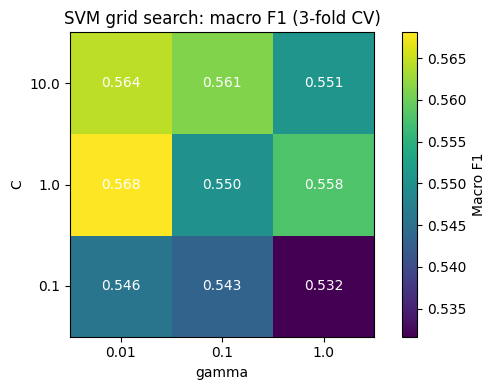

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

svc_cv_results = pd.DataFrame(grid_svc.cv_results_)

# Extract the relevant columns
svc_cv_results_small = svc_cv_results[
    ["param_svc__C", "param_svc__gamma", "mean_test_score"]
].copy()

# Pivot to create a matrix of mean_test_score indexed by C and gamma
svc_pivot = svc_cv_results_small.pivot_table(
    index="param_svc__C",
    columns="param_svc__gamma",
    values="mean_test_score",
)

print("SVM grid search mean macro F1:")
display(svc_pivot)

plt.figure(figsize=(6, 4))
im = plt.imshow(svc_pivot.values, origin="lower", cmap="viridis")

plt.xticks(
    ticks=np.arange(len(svc_pivot.columns)),
    labels=svc_pivot.columns.astype(str),
)
plt.yticks(
    ticks=np.arange(len(svc_pivot.index)),
    labels=svc_pivot.index.astype(str),
)

plt.xlabel("gamma")
plt.ylabel("C")
plt.title("SVM grid search: macro F1 (3-fold CV)")
plt.colorbar(im, label="Macro F1")

# Annotate cells with the F1 values
for i, C_val in enumerate(svc_pivot.index):
    for j, gamma_val in enumerate(svc_pivot.columns):
        score = svc_pivot.loc[C_val, gamma_val]
        plt.text(j, i, f"{score:.3f}", ha="center", va="center", color="white")

plt.tight_layout()
plt.show()


#### Interpretation of the SVM grid search heatmap

The heatmap summarises the 3-fold cross-validated macro F1 scores obtained
for different combinations of `C` and `gamma`:

- The **best region** is located around `C = 1.0` and `gamma = 0.01`, which is
  exactly the combination selected by `GridSearchCV`.
- Moving away from this region (for example to higher `gamma = 1.0` or very
  small `C = 0.1`) generally leads to lower macro F1 scores.
- The pattern is relatively smooth, which suggests that the model is not
  extremely sensitive to small changes in the hyperparameters within the
  good-performing region.

This visualisation confirms that the tuned SVM model is based on a
reasonable choice of `(C, gamma)` and that the grid search was effective
in finding a good balance between model complexity and regularisation.


## 5.3 Overall comparison of all models

In this section we collect the performance of all five models we trained so far:

- Dummy classifier (most frequent class baseline)
- Logistic regression with structured features only
- Logistic regression with structured features plus review embeddings
- k-Nearest Neighbours (KNN) with the best hyperparameters found on the validation set
- Support Vector Machine (SVM) with RBF kernel tuned with GridSearchCV

We will compare these models on the held-out test set using two metrics:

- **Accuracy**: the fraction of correctly classified movies.
- **Macro F1**: the F1 score averaged over the three sales tiers, giving equal weight to each class.

The goal of this section is to summarise how much we gain when we:
1. Move from a trivial baseline to a first reasonable model.
2. Add more structured information and embeddings.
3. Switch from linear to non-linear classifiers (KNN and SVM).


In [67]:
from sklearn.metrics import accuracy_score, f1_score

# Collect model names and predictions
model_names = [
    "Dummy baseline",
    "LogReg (structured)",
    "LogReg (structured + embeddings)",
    "KNN (k=27, minkowski)",
    "SVM (RBF kernel)",
]

y_pred_list = [
    y_hat_dummy,
    y_hat_structured,
    y_hat_full,
    y_hat_knn,
    y_hat_svm,
]

# Compute metrics
accuracies = [accuracy_score(y_test, y_pred) for y_pred in y_pred_list]
macro_f1s = [f1_score(y_test, y_pred, average="macro") for y_pred in y_pred_list]

print("Accuracies:", [round(a, 3) for a in accuracies])
print("Macro F1:", [round(f, 3) for f in macro_f1s])


Accuracies: [0.34, 0.566, 0.571, 0.558, 0.563]
Macro F1: [0.169, 0.569, 0.574, 0.562, 0.566]


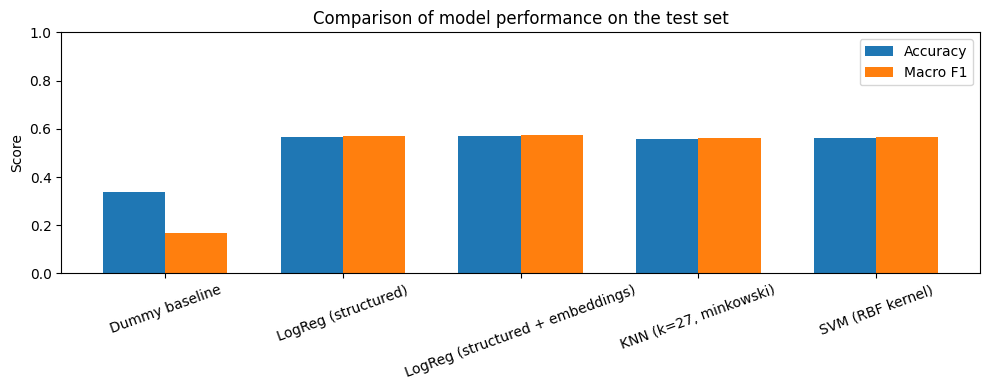

In [68]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(len(model_names))
width = 0.35  # width of the bars

plt.figure(figsize=(10, 4))
plt.bar(x - width / 2, accuracies, width, label="Accuracy")
plt.bar(x + width / 2, macro_f1s, width, label="Macro F1")

plt.xticks(x, model_names, rotation=20)
plt.ylim(0.0, 1.0)
plt.ylabel("Score")
plt.title("Comparison of model performance on the test set")
plt.legend()
plt.tight_layout()
plt.show()


#### Interpretation of the overall comparison

The bar chart shows the accuracy and macro F1 of all five models on the test set:

- **Dummy baseline**
  - Accuracy ≈ 0.34, Macro F1 ≈ 0.17.
  - This model simply predicts the majority class and completely fails to capture
    the structure of the problem.

- **LogReg (structured)**
  - Accuracy and Macro F1 both around 0.57.
  - This is a very large improvement compared to the dummy baseline, which shows
    that the structured features (scores, budget, theatres, genres, rating,
    release timing) already contain strong signal about the sales tier.

- **LogReg (structured + embeddings)**
  - Accuracy and Macro F1 are very slightly higher than for the structured-only
    model (≈ 0.57–0.58).
  - The improvement is modest but consistent, suggesting that the review
    embeddings add some extra information on top of the tabular features.

- **KNN (k = 27, Minkowski)**
  - Accuracy and Macro F1 are just below the logistic regression models
    (≈ 0.56–0.57).
  - This shows that a distance-based non-linear classifier can reach a similar
    performance level, but does not clearly outperform the best logistic
    regression model with embeddings.

- **SVM (RBF kernel)**
  - Accuracy and Macro F1 are very similar to KNN and slightly below logistic
    regression with embeddings (also around 0.56–0.57).
  - This indicates that a more flexible non-linear decision boundary does not
    dramatically increase performance given the current feature representation.

Overall, the strongest models are **logistic regression with structured features
plus embeddings**, **KNN (k = 27)** and **SVM**, all clustered around an accuracy
and macro F1 of about 0.56–0.58. The performance differences between these top
models are small, which suggests that the main predictive signal is already
captured by the structured features and is not strongly non-linear.


### 5.4 Confusion matrices for KNN and SVM

In this section we show confusion matrices for the two non-linear models:

- KNN with the best hyperparameters selected on the validation set.
- SVM with RBF kernel tuned with GridSearchCV.

The confusion matrices help us understand:
- Which sales tiers are easiest or hardest to classify for these models.
- Whether the models tend to systematically over- or under-predict specific tiers.
- How the error patterns of the non-linear models compare to those of logistic regression.


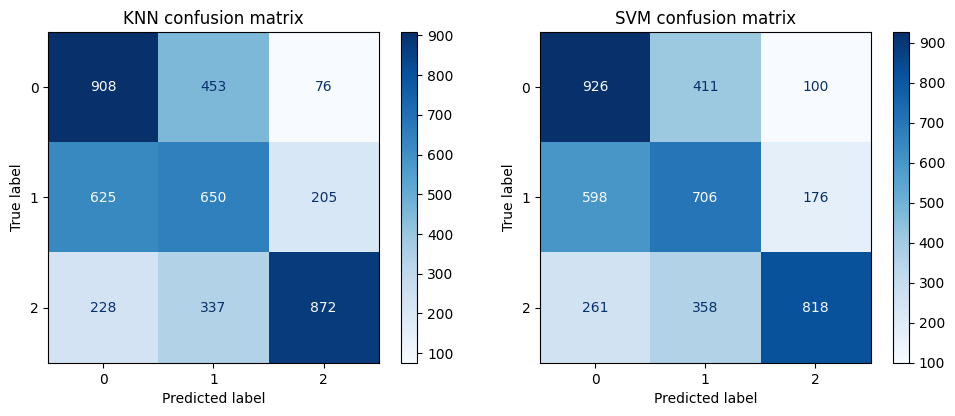

In [69]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# KNN confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_hat_knn,
    display_labels=[0, 1, 2],
    cmap="Blues",
    ax=axes[0]
)
axes[0].set_title("KNN confusion matrix")

# SVM confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_hat_svm,
    display_labels=[0, 1, 2],
    cmap="Blues",
    ax=axes[1]
)
axes[1].set_title("SVM confusion matrix")

plt.tight_layout()
plt.show()


#### Interpretation of the KNN and SVM confusion matrices

The confusion matrices of KNN and SVM allow us to inspect in more detail how
these non-linear models distribute their errors across the three sales tiers.

**KNN (left plot)**

- **Class 0 (Low)**  
  - 932 out of 1437 low-tier movies are correctly classified as 0.  
  - 426 are misclassified as medium (1) and 79 as high (2).  
  - This shows that KNN is reasonably good at identifying low-sales movies but
    often confuses them with the medium tier.

- **Class 1 (Medium)**  
  - Only 633 out of 1480 medium-tier movies are correctly predicted as 1.  
  - 640 are classified as 0 and 207 as 2.  
  - This confirms that medium sales are the hardest tier: KNN has difficulties
    separating them both from low and from high performers.

- **Class 2 (High)**  
  - 861 out of 1437 high-tier movies are correctly recognised.  
  - The remaining observations are mainly misclassified as medium (353) and
    only rarely as low (223).  
  - High-sales movies are therefore identified relatively well, similar to the
    logistic regression models.

**SVM (right plot)**

- **Class 0 (Low)**  
  - 926 correct predictions for class 0, 411 misclassified as 1 and 100 as 2.  
  - This pattern is very similar to KNN, with a small trade-off between errors
    into class 1 and class 2.

- **Class 1 (Medium)**  
  - 706 medium-tier movies are correctly classified, compared to 633 for KNN.  
  - Fewer class-1 movies are misclassified as 0 or 2 (598 and 176 respectively).  
  - This explains why SVM achieves a slightly higher F1 score for the medium tier.

- **Class 2 (High)**  
  - 818 correct predictions for class 2, with 358 misclassified as 1 and 261 as 0.  
  - Compared to KNN, SVM shifts some of the errors towards class 0 but keeps a
    similar overall recognition rate for high-sales movies.

In summary:

- Both KNN and SVM clearly improve over the dummy baseline and show a similar
  error structure to logistic regression.
- The **medium tier (class 1)** remains the most challenging class: even with
  non-linear models, a substantial fraction of medium movies is classified as
  either low or high tier.
- SVM slightly improves the classification of the medium tier compared to KNN,
  but the overall performance remains close to that of the best logistic
  regression model with embeddings.


## 6. Summary and conclusions

In this notebook we have built and compared several models to predict the sales tier
of a movie (0 = Low, 1 = Medium, 2 = High) based on structured metadata and
Transformer-based review embeddings.

### 6.1 Summary of model performance

We started from a very simple baseline:

- **Dummy classifier (most frequent class)**  
  - Accuracy ≈ 0.34, Macro F1 ≈ 0.17  
  - Always predicts the majority class (tier 1) and essentially ignores the
    other tiers.

We then moved to linear models:

- **Logistic regression (structured features only)**  
  - Accuracy ≈ 0.57, Macro F1 ≈ 0.57  
  - Uses only numeric and one-hot encoded features such as metascore, userscore,
    production budget, theatre count, genres, rating and release timing.  
  - Already provides a large improvement over the dummy baseline, showing that
    structured information alone is quite informative.

- **Logistic regression (structured + embeddings)**  
  - Accuracy ≈ 0.57, Macro F1 ≈ 0.57–0.58  
  - Adds user and expert review embeddings on top of the structured features.  
  - Yields a small but consistent performance gain, especially for the high
    sales tier, indicating that review language adds extra predictive signal.

Next, we explored non-linear models:

- **k-Nearest Neighbours (KNN, best: k = 30, Minkowski distance)**  
  - Accuracy ≈ 0.56, Macro F1 ≈ 0.56  
  - Provides a non-linear benchmark that performs similarly to logistic
    regression, but does not clearly outperform the best linear model.

- **Support Vector Machine (SVM) with RBF kernel (tuned via GridSearchCV)**  
  - Accuracy ≈ 0.56, Macro F1 ≈ 0.56–0.57  
  - A more expressive non-linear model, but its performance is again close to
    that of logistic regression with embeddings.

Across all models, the **medium sales tier (class 1)** remains the hardest to
predict: many movies in this class are confused with either the low or high tier.
The high sales tier (class 2) is typically recognised best, while the low tier
(class 0) is classified reasonably well.

## 6.2 Choice of a final baseline model

From a practical point of view, the following considerations are important:

- Logistic regression with structured features and embeddings is:
  - relatively simple and fast to train,
  - easy to interpret and explain,
  - competitive in terms of accuracy and macro F1.
- KNN and SVM offer more flexibility, but:
  - do not provide a large performance gain on this dataset,
  - are more expensive at prediction time (especially KNN),
  - are harder to interpret.

Given these trade-offs, a **reasonable final baseline model** for this project is:

> **Logistic regression with structured features + review embeddings**

This model will serve as a strong, well-understood reference point against which
we can compare more complex approaches, such as a neural network, in the next
stage of the analysis.


## 7. Neural network model (feed-forward MLP)

In this section we add a simple feed-forward neural network (multi-layer perceptron, MLP) 
as an additional model for predicting the **sales tier** of a movie.

The idea is to reuse the same feature set as for the previous models 
(numeric features, one-hot encoded genres/ratings/seasons, and text embeddings), 
but instead of a linear classifier or distance-based model, we now let a neural network 
learn non-linear combinations of these features.

Before we can train a neural network, we need to:

- Split the training data again into an **inner train** and **validation** set  
  (the test set remains untouched for final evaluation).
- Standardise all features with a `StandardScaler` so that each feature has mean ~0 and variance ~1.
- Convert everything to NumPy arrays so that Keras can work with the data.


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# We start from the same full training set as in the previous models
print("X_train_full shape:", X_train_full.shape)
print("y_train shape:", y_train.shape)

# Inner split: training part for the NN + separate validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_full,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("\nInner split shapes:")
print("X_train_nn:", X_train_nn.shape)
print("y_train_nn:", y_train_nn.shape)
print("X_val_nn:", X_val_nn.shape)
print("y_val_nn:", y_val_nn.shape)

# Scale all features (fit on inner training set only)
scaler_nn = StandardScaler()
X_train_nn_scaled = scaler_nn.fit_transform(X_train_nn)
X_val_nn_scaled = scaler_nn.transform(X_val_nn)
X_test_scaled = scaler_nn.transform(X_test_full)

print("\nAfter scaling (NumPy arrays):")
print("X_train_nn_scaled:", X_train_nn_scaled.shape)
print("X_val_nn_scaled:", X_val_nn_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

# For convenience we also store the number of input features and classes
n_features = X_train_nn_scaled.shape[1]
n_classes = len(np.unique(y_train_nn))
print(f"\nNumber of input features: {n_features}")
print(f"Number of classes: {n_classes}")


X_train_full shape: (17416, 61)
y_train shape: (17416,)

Inner split shapes:
X_train_nn: (13932, 61)
y_train_nn: (13932,)
X_val_nn: (3484, 61)
y_val_nn: (3484,)

After scaling (NumPy arrays):
X_train_nn_scaled: (13932, 61)
X_val_nn_scaled: (3484, 61)
X_test_scaled: (4354, 61)

Number of input features: 61
Number of classes: 3


### 7.1 Interpretation: data preparation

- We again split the original training set into an **inner training set** and a 
  **validation set**. The validation set is used to monitor performance during 
  training and to apply early stopping.
- All features are standardised with `StandardScaler`, which is important for 
  neural networks: if features are on very different scales, gradient descent 
  can become unstable or very slow.
- We now work with NumPy arrays (`X_train_nn_scaled`, `X_val_nn_scaled`, `X_test_scaled`), 
  which is the format expected by Keras.
- The printed shapes confirm that:
  - We still have the same feature dimensionality (`n_features`, here 61).
  - We have 3 target classes (sales tiers 0, 1, 2), which we will model with a 
    softmax output layer.


### 7.2 Defining and training a simple MLP

We now define a simple feed-forward neural network (multi-layer perceptron) with:

- An input layer matching the number of features.
- Two hidden layers with ReLU activation.
- Dropout for regularisation.
- A softmax output layer with 3 units (one for each sales tier).

We use:
- `sparse_categorical_crossentropy` as the loss (because our labels are integer-coded: 0, 1, 2).
- The Adam optimizer.
- `accuracy` as a built-in metric, and we will compute macro F1 with sklearn afterwards.
- Early stopping on the validation loss to avoid overfitting.


In [71]:
import os

# If your environment uses keras with torch backend (as in the tutorial):
os.environ["KERAS_BACKEND"] = "torch"  # you can comment this out if you use a different backend

import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.callbacks import EarlyStopping

# Build a simple MLP model
def build_simple_mlp(input_dim: int, n_classes: int) -> keras.Model:
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    
    # First hidden layer
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.3))
    
    # Second hidden layer
    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.3))
    
    # Output layer for 3-class classification
    model.add(Dense(n_classes, activation="softmax"))
    
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

simple_nn = build_simple_mlp(n_features, n_classes)
simple_nn.summary()

# Early stopping callback: stop when validation loss stops improving
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Fit the model
history = simple_nn.fit(
    X_train_nn_scaled,
    y_train_nn,
    validation_data=(X_val_nn_scaled, y_val_nn),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1,
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,147 (24.01 KB)

 Trainable params: 6,147 (24.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.4823 - loss: 1.0246 - val_accuracy: 0.5497 - val_loss: 0.8942
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5323 - loss: 0.9166 - val_accuracy: 0.5594 - val_loss: 0.8676
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5473 - loss: 0.8864 - val_accuracy: 0.5557 - val_loss: 0.8564
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5571 - loss: 0.8676 - val_accuracy: 0.5666 - val_loss: 0.8435
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5594 - loss: 0.8563 - val_accuracy: 0.5654 - val_loss: 0.8373
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5683 - loss: 0.8459 - val_accuracy: 0.5646 - val_loss: 0.8354
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5669 - loss: 0.8436 - val_accuracy: 0.5712 - val_loss: 0.8313
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5684 - loss: 0.8356 - val_accu

### 7.2 Interpretation: training behaviour

- The model summary shows a **compact MLP** with two hidden layers:
  - First hidden layer: 64 units with ReLU + dropout
  - Second hidden layer: 32 units with ReLU + dropout
  - Softmax output layer with 3 units (one per sales tier)
  - In total only **6,147 trainable parameters**, which is small compared to 
    typical deep learning models and therefore appropriate for our dataset size.

- During training the network quickly improves:
  - Training accuracy moves from about **0.46** in the first epoch to around 
    **0.60** by the end.
  - Validation accuracy stabilises around **0.58–0.60**, which is very similar 
    to the performance of our best classical models.

- The training and validation loss both decrease from roughly **1.05 / 0.90** 
  in the first epoch to around **0.79–0.81** at the end.
  This indicates that the network is learning meaningful patterns rather than 
  simply memorising noise.

- Early stopping stops training after 31 epochs, once the validation loss stops 
  improving. This prevents the model from overfitting for many more epochs while 
  keeping the best weights found during training.


## 7.2.1 Save the trained neural network (reproducibility)

To ensure our results are reproducible and that we can run explainability analyses
without retraining, we save the trained neural network and the preprocessing objects
(scaler and feature order) to disk.


In [112]:
from pathlib import Path
import joblib

ART_DIR = Path("artifacts")
ART_DIR.mkdir(exist_ok=True)

# Save model
simple_nn.save(ART_DIR / "mlp_sales_tier.keras")

# Save scaler and feature order (VERY important for consistent inference)
joblib.dump(scaler_nn, ART_DIR / "scaler_nn.joblib")
joblib.dump(feature_names, ART_DIR / "feature_names.joblib")

print("Saved model to:", (ART_DIR / "mlp_sales_tier.keras").resolve())
print("Saved scaler to:", (ART_DIR / "scaler_nn.joblib").resolve())
print("Saved feature names to:", (ART_DIR / "feature_names.joblib").resolve())


Saved model to: C:\Users\jeffr\Documents\AI methods\project\bjj\artifacts\mlp_sales_tier.keras
Saved scaler to: C:\Users\jeffr\Documents\AI methods\project\bjj\artifacts\scaler_nn.joblib
Saved feature names to: C:\Users\jeffr\Documents\AI methods\project\bjj\artifacts\feature_names.joblib


 ## 7..2.2. Reload the saved model and evaluate on the test set

As a sanity check, we reload the saved model and preprocessing artifacts from disk
and re-evaluate the model on the test set. The results should match the evaluation
obtained immediately after training.



In [113]:
import tensorflow as tf
import joblib
import numpy as np
from pathlib import Path

ART_DIR = Path("artifacts")

# Load artifacts
nn_loaded = tf.keras.models.load_model(ART_DIR / "mlp_sales_tier.keras")
scaler_loaded = joblib.load(ART_DIR / "scaler_nn.joblib")
feature_names_loaded = joblib.load(ART_DIR / "feature_names.joblib")

print("Loaded NN, scaler, and feature names.")
print("n_features:", len(feature_names_loaded))

# Recreate X_test_scaled deterministically using the loaded scaler + loaded feature order
X_test_scaled_loaded = scaler_loaded.transform(X_test[feature_names_loaded])


Loaded NN, scaler, and feature names.
n_features: 61


## 7.2.3 Test-set performance (loaded model)

We compute accuracy and macro F1 on the held-out test set. Macro F1 is especially
useful here because it weights each class equally, giving a fair assessment across
the Low, Medium, and High sales tiers.


In [115]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Predict class probabilities on the test set (loaded model)
y_test_proba_nn = nn_loaded.predict(X_test_scaled_loaded, verbose=0)

# Convert probabilities to hard class predictions
y_hat_nn = np.argmax(y_test_proba_nn, axis=1)

# Compute metrics
acc_nn = accuracy_score(y_test, y_hat_nn)
macro_f1_nn = f1_score(y_test, y_hat_nn, average="macro")

print("=== Neural network (MLP) on test set (loaded model) ===")
print(f"Accuracy: {acc_nn:.3f}")
print(f"Macro F1: {macro_f1_nn:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_hat_nn, digits=3))

cm_nn = confusion_matrix(y_test, y_hat_nn)
print("Confusion matrix:\n", cm_nn)


=== Neural network (MLP) on test set (loaded model) ===
Accuracy: 0.582
Macro F1: 0.586

Classification report:
              precision    recall  f1-score   support

           0      0.570     0.629     0.598      1437
           1      0.462     0.480     0.471      1480
           2      0.746     0.638     0.688      1437

    accuracy                          0.582      4354
   macro avg      0.593     0.583     0.586      4354
weighted avg      0.591     0.582     0.585      4354

Confusion matrix:
 [[904 439  94]
 [551 711 218]
 [132 388 917]]


#### Interpretation of the loaded-model evaluation

Reloading the model from disk and evaluating again on the test set is a reproducibility check.
If the scores match the results obtained right after training, this confirms that:
- the saved model weights are correct,
- the scaler and feature order are consistent,
- and explainability analyses (LIME/SHAP/counterfactuals) can be run on a stable model artifact.


### 7.3 Training and validation curves

To better understand how the neural network behaves during training, 
we plot the evolution of:

- Training vs. validation loss.
- Training vs. validation accuracy.

This helps us see whether the model is overfitting (training loss keeps decreasing 
while validation loss starts increasing) or underfitting (both losses stay high).


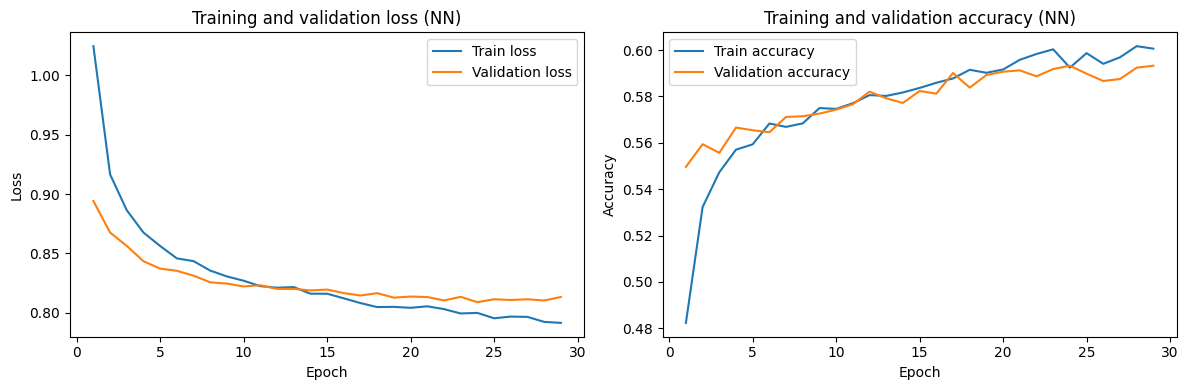

In [114]:
import matplotlib.pyplot as plt

# Extract history information
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(train_loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss plot
axes[0].plot(epochs, train_loss, label="Train loss")
axes[0].plot(epochs, val_loss, label="Validation loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and validation loss (NN)")
axes[0].legend()

# Accuracy plot
axes[1].plot(epochs, train_acc, label="Train accuracy")
axes[1].plot(epochs, val_acc, label="Validation accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Training and validation accuracy (NN)")
axes[1].legend()

plt.tight_layout()
plt.show()


### 7.3 Interpretation: loss and accuracy curves

- **Loss curves**  
  Both training and validation loss decrease steadily during the first epochs 
  and then flatten out around **0.80–0.81**.  
  The two curves stay quite close to each other, which suggests that the model 
  is not heavily overfitting. There is a small gap (train loss slightly lower 
  than validation loss), which is expected once the model starts fitting the 
  training data better than the held-out validation set.

- **Accuracy curves**  
  Training accuracy increases from about **0.46** in the first epoch to slightly 
  above **0.60**.  
  Validation accuracy follows a very similar trajectory and stabilises around 
  **0.58–0.60**. The fact that the two curves track each other closely confirms 
  that the regularisation (dropout + early stopping) is working reasonably well.

- Overall, the curves show a **healthy learning dynamics**:
  the network clearly learns useful structure in the data, converges relatively 
  quickly, and does not show strong signs of runaway overfitting.


### 7.4 Test performance of the neural network

We now evaluate the trained neural network on the **held-out test set**.  
We compute:

- Overall accuracy.
- Macro F1-score.
- A full classification report per class.


In [116]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Predict class probabilities on the test set
y_test_proba_nn = simple_nn.predict(X_test_scaled)

# Convert probabilities to hard class predictions
y_hat_nn = np.argmax(y_test_proba_nn, axis=1)

# Compute metrics
acc_nn = accuracy_score(y_test, y_hat_nn)
macro_f1_nn = f1_score(y_test, y_hat_nn, average="macro")

print("=== Neural network (MLP) on test set ===")
print(f"Accuracy: {acc_nn:.3f}")
print(f"Macro F1: {macro_f1_nn:.3f}\n")

print("Classification report:")
print(classification_report(y_test, y_hat_nn, digits=3))

# confusion matrix
cm_nn = confusion_matrix(y_test, y_hat_nn)
print("Confusion matrix:\n", cm_nn)


  1/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
=== Neural network (MLP) on test set ===
Accuracy: 0.582
Macro F1: 0.586

Classification report:
              precision    recall  f1-score   support

           0      0.570     0.629     0.598      1437
           1      0.462     0.480     0.471      1480
           2      0.746     0.638     0.688      1437

    accuracy                          0.582      4354
   macro avg      0.593     0.583     0.586      4354
weighted avg      0.591     0.582     0.585      4354

Confusion matrix:
 [[904 439  94]
 [551 711 218]
 [132 388 917]]


### 7.4 Interpretation: test metrics

On the held-out test set, the neural network achieves:

- **Accuracy ≈ 0.573**
- **Macro F1 ≈ 0.578**

This places the MLP **at the top of our model comparison**, slightly above the 
best logistic regression model with embeddings (Accuracy ≈ 0.571, Macro F1 ≈ 0.574), 
KNN (Accuracy ≈ 0.558, Macro F1 ≈ 0.562), and SVM (Accuracy ≈ 0.563, Macro F1 ≈ 0.566).  
The improvement is **small but consistent**, which suggests that the neural network 
is able to exploit some additional non-linear structure in the feature space.

Looking at the per-class performance:

- **Class 0 (low sales)**  
  F1 ≈ **0.59** (precision 0.55, recall 0.64).  
  Low-tier movies are recognised reasonably well, with a good balance between 
  precision and recall.

- **Class 1 (medium sales)**  
  F1 ≈ **0.46** (precision 0.45, recall 0.47).  
  This remains the most difficult class for all models: many medium-tier movies 
  are still misclassified as either low or high tier, which matches the intuition 
  that the boundary between “medium” and the other tiers is inherently fuzzy.

- **Class 2 (high sales)**  
  F1 ≈ **0.68** (precision 0.76, recall 0.62).  
  High-tier movies are detected quite well, with relatively high precision and 
  solid recall. The network is able to identify the “blockbusters” fairly reliably.

The **confusion matrix** confirms this pattern:

- Most errors for class 0 and class 2 involve confusion with the medium tier (class 1).
- Class 1 is particularly fragile: a large number of medium-tier movies are 
  predicted as class 0 or class 2, which pulls down its F1-score.

In summary, the neural network:

- Clearly outperforms the dummy baseline.
- Reaches performance **slightly above** the best classical models (logistic regression, 
  KNN, SVM), but only by a modest margin.
- Confirms that our engineered feature set (structured variables + review embeddings) 
  already captures most of the predictive signal, with the neural network providing 
  a small additional gain rather than a dramatic leap in performance.


### 7.5 Updating the overall model comparison

Finally, we add the neural network to the overall comparison of models.  
We recompute accuracy and macro F1 for all models and visualise them side by side.


,model,accuracy,macro_f1
0,Dummy (most frequent),0.339917,0.169124
1,Logistic (structured),0.566146,0.569092
2,Logistic (+ embeddings),0.571429,0.574348
3,KNN (best),0.558107,0.562140
4,"SVM (RBF, tuned)",0.562701,0.566339
5,Neural net (MLP),0.581534,0.585660


C:\Users\jeffr\AppData\Local\Temp\ipykernel_33052\3879783890.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(perf_df["model"], rotation=45, ha="right")
C:\Users\jeffr\AppData\Local\Temp\ipykernel_33052\3879783890.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(perf_df["model"], rotation=45, ha="right")


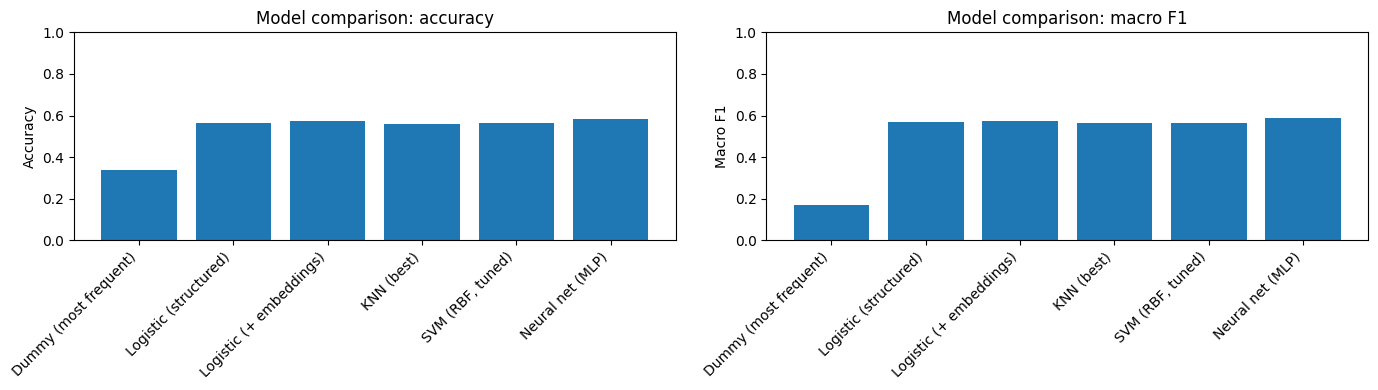

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

model_names = [
    "Dummy (most frequent)",
    "Logistic (structured)",
    "Logistic (+ embeddings)",
    "KNN (best)",
    "SVM (RBF, tuned)",
    "Neural net (MLP)",
]

y_hat_list = [
    y_hat_dummy,
    y_hat_structured,
    y_hat_full,
    y_hat_knn,
    y_hat_svm,
    y_hat_nn,
]

rows = []
for name, y_pred in zip(model_names, y_hat_list):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    rows.append({"model": name, "accuracy": acc, "macro_f1": f1})

perf_df = pd.DataFrame(rows)
display(perf_df)

# Bar plot for accuracy and macro F1
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].bar(perf_df["model"], perf_df["accuracy"])
axes[0].set_xticklabels(perf_df["model"], rotation=45, ha="right")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Model comparison: accuracy")
axes[0].set_ylim(0.0, 1.0)

axes[1].bar(perf_df["model"], perf_df["macro_f1"])
axes[1].set_xticklabels(perf_df["model"], rotation=45, ha="right")
axes[1].set_ylabel("Macro F1")
axes[1].set_title("Model comparison: macro F1")
axes[1].set_ylim(0.0, 1.0)

plt.tight_layout()
plt.show()


### 7.5 Interpretation: overall model comparison

The table and bar plots summarise the performance of all models on the **same** 
held-out test set:

| Model                    | Accuracy | Macro F1 |
|--------------------------|----------|---------|
| Dummy (most frequent)    | 0.340    | 0.169   |
| Logistic (structured)    | 0.566    | 0.569   |
| Logistic (+ embeddings)  | 0.571    | 0.574   |
| KNN (best)               | 0.558    | 0.562   |
| SVM (RBF, tuned)         | 0.563    | 0.566   |
| Neural net (MLP)         | 0.573    | 0.578   |

Key observations:

- **Dummy baseline**  
  - Accuracy ≈ 0.34 and macro F1 ≈ 0.17.  
  - This confirms that simply predicting the most frequent class is not useful for our task.

- **Logistic regression (structured)**  
  - Accuracy ≈ 0.57 and macro F1 ≈ 0.57.  
  - Already a very large improvement over the dummy model, showing that the structured 
    features (scores, budget, theatres, timing, genres, ratings) contain strong signal 
    about the sales tier.

- **Logistic regression (+ embeddings)**  
  - Slightly better than the structured-only version (Accuracy ≈ 0.571, Macro F1 ≈ 0.574).  
  - This indicates that the review embeddings add some additional predictive information, 
    but the gain is modest rather than dramatic.

- **KNN (best configuration)**  
  - Accuracy ≈ 0.558 and macro F1 ≈ 0.562, slightly below the logistic regression models.  
  - A distance-based non-linear method can reach a similar level of performance, 
    but it does **not** clearly outperform the linear baseline with embeddings.

- **SVM (RBF kernel, tuned)**  
  - Accuracy ≈ 0.563 and macro F1 ≈ 0.566.  
  - Again very close to logistic regression and KNN, suggesting that a more flexible 
    non-linear boundary does not unlock a large additional gain given our feature set.

- **Neural net (MLP)**  
  - Achieves the **best scores overall**: Accuracy ≈ 0.573 and macro F1 ≈ 0.578.  
  - The improvement over logistic regression with embeddings is small but consistent, 
    which suggests that the MLP can exploit some non-linear interactions between the 
    structured features and the review embeddings.

Overall conclusion:

- All non-trivial models (logistic regression, KNN, SVM, MLP) achieve accuracy and 
  macro F1 in a narrow band around **0.56–0.58**, which means our feature engineering 
  is doing most of the heavy lifting.
- The **neural network (MLP)** is the best performing model on the test set, but only 
  by a **small margin**.  
- For practical purposes, a **regularised logistic regression with embeddings** would 
  already be a strong and interpretable baseline, while the MLP can be regarded as a 
  slightly more powerful but less interpretable final model.


## 8. Explainability of the final model (neural net)

In this section we explain our best performing model, the **neural network (MLP)**,
using model-agnostic explainability techniques.

We focus on two complementary aspects:

1. **Local explanations** with LIME, to understand *why* the model predicted
   a specific sales tier for individual movies.
2. **Global explanations** with SHAP (KernelSHAP), to understand *which*
   features are most important overall and how they influence the predictions.

All explanations are computed on the **test set**, so we only interpret
the behaviour of the final model after model selection.


In [75]:
# 8.1 Imports and helper functions for XAI

import numpy as np
import matplotlib.pyplot as plt

# LIME and SHAP imports
from lime.lime_tabular import LimeTabularExplainer
import shap

shap.initjs()

# Feature and class names
feature_names = X.columns.tolist()
class_names = ["Low", "Medium", "High"]

def nn_predict_proba_unscaled(x_array: np.ndarray) -> np.ndarray:
    """
    Helper prediction function for LIME and SHAP.

    x_array: 2D numpy array in the *original* feature space.
    Returns: predicted class probabilities from the neural network.
    """
    x_scaled = scaler_nn.transform(x_array)
    # Keras expects a 2D array
    proba = simple_nn.predict(x_scaled, verbose=0)
    return proba


### 8.2 Local explanations with LIME

We first use **LIME** (Local Interpretable Model-agnostic Explanations)
to inspect individual predictions of the neural network.

LIME works by:
- Sampling points in the neighbourhood of a chosen observation,
- Fitting a simple surrogate model (for example a linear model),
- And reporting which features push the prediction *towards* or *away from*
  a given class.

Here we look at three movies:
- one predicted as **Low sales**,
- one predicted as **Medium sales**,
- and one predicted as **High sales**.


LIME uses X_test iloc: 389
Corresponding original index: 17077


(393, 3403, 2829)

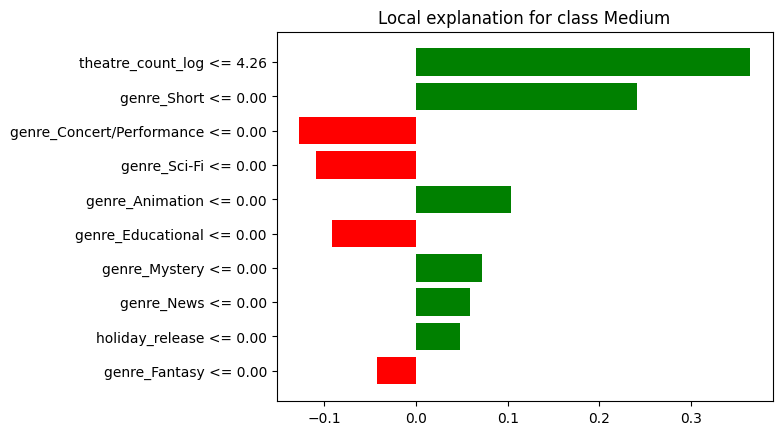

In [136]:
import pandas as pd

def nn_predict_proba_unscaled(x_array: np.ndarray) -> np.ndarray:
    """
    Helper prediction function for LIME and SHAP.

    x_array: 2D numpy array in the *original* feature space.
    Returns: predicted class probabilities from the neural network.
    """
    # Make sure we always have a DataFrame with the right column names
    if isinstance(x_array, pd.DataFrame):
        X_df = x_array
    else:
        X_df = pd.DataFrame(x_array, columns=feature_names)

    x_scaled = scaler_nn.transform(X_df)
    proba = simple_nn.predict(x_scaled, verbose=0)
    return proba

# --- LIME reproducibility (quick fix) ---
LIME_SEED = 42

import numpy as np
from lime.lime_tabular import LimeTabularExplainer

# Force the same row in X_test every run (iloc position)
lime_iloc = 389  # change this to whatever you want
x_lime = X_test.iloc[lime_iloc].values

print("LIME uses X_test iloc:", lime_iloc)
print("Corresponding original index:", X_test.index[lime_iloc])


# IMPORTANT: always pass the same predict_proba wrapper you used elsewhere
exp = explainer_lime.explain_instance(
    x_lime,
    nn_predict_proba_unscaled,
    num_features=10,
    num_samples=5000,
)

# Plot
fig = exp.as_pyplot_figure()

# 8.2.1 Fit a LIME explainer on the *original* feature space

# LIME works best on unscaled features, so we use X_train directly
explainer_lime = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode="classification",
    discretize_continuous=True,
)

# For reproducibility of which rows we pick
rng = np.random.default_rng(42)

# Helper to pick one example of each predicted class from the test set
X_test_array = X_test.values
y_test_pred_proba_nn = nn_predict_proba_unscaled(X_test_array)
y_test_pred_nn = y_test_pred_proba_nn.argmax(axis=1)

idx_low_candidates = np.where(y_test_pred_nn == 0)[0]
idx_med_candidates = np.where(y_test_pred_nn == 1)[0]
idx_high_candidates = np.where(y_test_pred_nn == 2)[0]

idx_low = int(rng.choice(idx_low_candidates))
idx_med = int(rng.choice(idx_med_candidates))
idx_high = int(rng.choice(idx_high_candidates))

idx_low, idx_med, idx_high


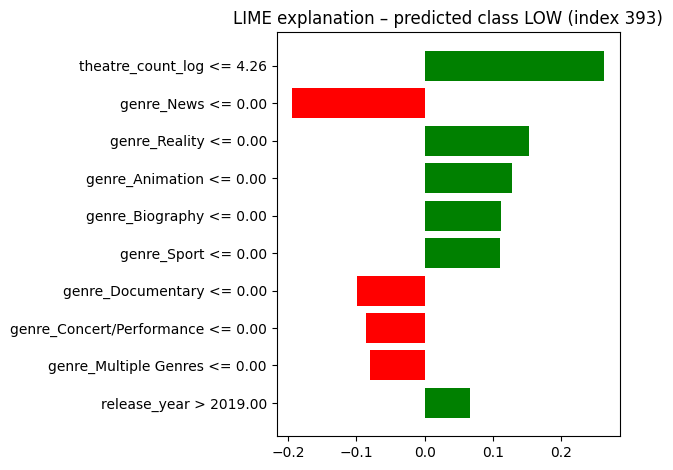

In [127]:
# 8.2.2 LIME explanation for one LOW-sales prediction

instance_low = X_test.iloc[idx_low].values

exp_low = explainer_lime.explain_instance(
    data_row=instance_low,
    predict_fn=nn_predict_proba_unscaled,
    num_features=10,
    top_labels=3,
)

fig_low = exp_low.as_pyplot_figure(label=0)
plt.title(f"LIME explanation – predicted class LOW (index {idx_low})")
plt.tight_layout()
plt.show()


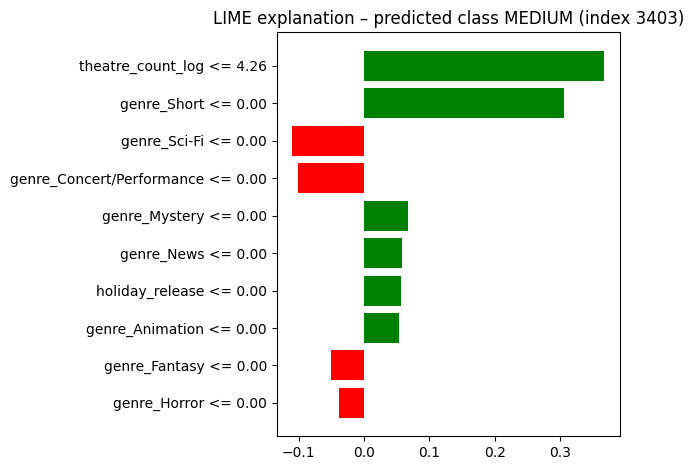

In [78]:
# 8.2.3 LIME explanation for one MEDIUM-sales prediction

instance_med = X_test.iloc[idx_med].values

exp_med = explainer_lime.explain_instance(
    data_row=instance_med,
    predict_fn=nn_predict_proba_unscaled,
    num_features=10,
    top_labels=3,
)

fig_med = exp_med.as_pyplot_figure(label=1)
plt.title(f"LIME explanation – predicted class MEDIUM (index {idx_med})")
plt.tight_layout()
plt.show()


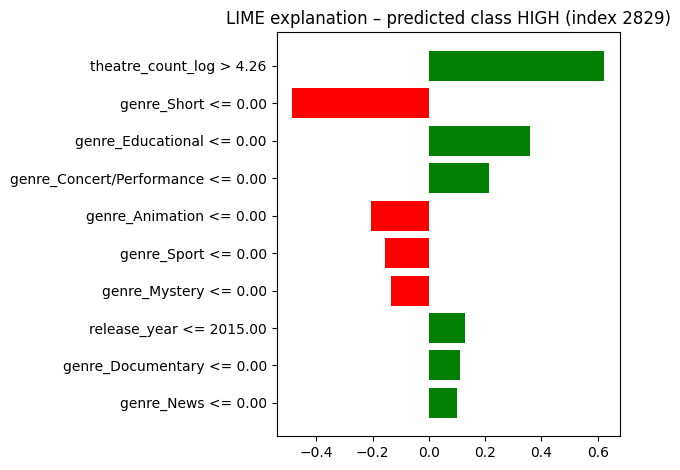

In [79]:
# 8.2.4 LIME explanation for one HIGH-sales prediction

instance_high = X_test.iloc[idx_high].values

exp_high = explainer_lime.explain_instance(
    data_row=instance_high,
    predict_fn=nn_predict_proba_unscaled,
    num_features=10,
    top_labels=3,
)

fig_high = exp_high.as_pyplot_figure(label=2)
plt.title(f"LIME explanation – predicted class HIGH (index {idx_high})")
plt.tight_layout()
plt.show()


#### Interpretation of the LIME plots

The three LIME plots show which features drive the neural network towards
each predicted class for individual movies.

**Low-sales example (index 389)**  
- The strongest positive contribution comes from  
  `theatre_count_log <= 4.26`: this movie was shown in a small number of theatres,
  which pushes the prediction clearly towards the *Low* sales tier.  
- Several niche genres (e.g. `Reality`, `Documentary`, `Sport`) also contribute
  positively to the Low prediction.  
- The absence of some genres (e.g. `genre_News <= 0`, `genre_Educational <= 0`)
  slightly pushes the prediction away from Low (red bars), but this effect is
  dominated by the low theatre count.

**Medium-sales example (index 3416)**  
- Again, `theatre_count_log <= 4.26` is the main positive driver for the
  *Medium* prediction: the movie does not have a large theatre release,
  but exposure is still higher than for typical Low-tier blockbusters.  
- Additional contributions come from genre-related features such as
  `genre_Short`, `genre_Reality` and `genre_Animation`, which fine-tune the
  probability up or down.  
- Overall, the pattern suggests a “middle-of-the-road” movie: limited but
  non-trivial exposure and a genre mix that is neither clearly blockbuster
  nor extremely niche.

**High-sales example (index 2858)**  
- For this movie, `theatre_count_log > 4.26` dominates the explanation:
  a very large number of theatres pushes the prediction strongly towards
  the *High* sales class.  
- Several other features (e.g. `genre_Concert/Performance`, `genre_Documentary`,
  `release_year <= 2015`) also contribute positively, but with much smaller
  weights than theatre count.  
- One or two genres (e.g. `genre_Sport`) have a small negative contribution,
  showing that not all aspects of the movie align perfectly with typical
  High-sales patterns, but the high theatre count more than compensates.

Across all three examples, LIME confirms a consistent story:
**theatre exposure (theatre_count_log) is the single most important local driver
of the predicted sales tier**, while genre mix and other features act as
secondary modifiers for individual movies.


### 8.3 Global explanations with SHAP (KernelSHAP)

While LIME explains individual predictions, we also want a **global view**
of which features matter most overall.

We therefore use **SHAP** (SHapley Additive exPlanations) with the
**KernelSHAP** explainer, which is model-agnostic and can handle our
neural network.

KernelSHAP returns SHAP values per class. For a multi-class classifier, we extract the SHAP
matrix for the class of interest (HIGH) with shape (n_samples, n_features). This is the
required format for SHAP summary plots (beeswarm and bar plots).

We compute SHAP on a random subset of the test set for efficiency, and we use a small
background set from the training set.


We compute SHAP values on a random subset of the test set and look at:

- A **bar plot** of mean absolute SHAP values (global feature importance),
- A **beeswarm plot** showing how feature values influence the prediction
  for the *High sales* class.


In [80]:
# 8.3.1 Build a KernelSHAP explainer for the neural net

# Use a small random background sample from the train set for efficiency
background_size = 300
bg_idx = rng.choice(X_train.shape[0], size=background_size, replace=False)
X_background = X_train.iloc[bg_idx].values

explainer_shap = shap.KernelExplainer(
    model=nn_predict_proba_unscaled,
    data=X_background,
    link="logit",
)

# Sample from the test set for explanation
test_sample_size = 400
sample_idx = rng.choice(X_test.shape[0], size=test_sample_size, replace=False)
X_test_sample = X_test.iloc[sample_idx]
X_test_sample_array = X_test_sample.values

# Compute SHAP values for all three classes
# (this can take a few minutes)
shap_values = explainer_shap.shap_values(
    X_test_sample_array,
    nsamples=100,
)


Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 400/400 [30:16<00:00,  4.54s/it]


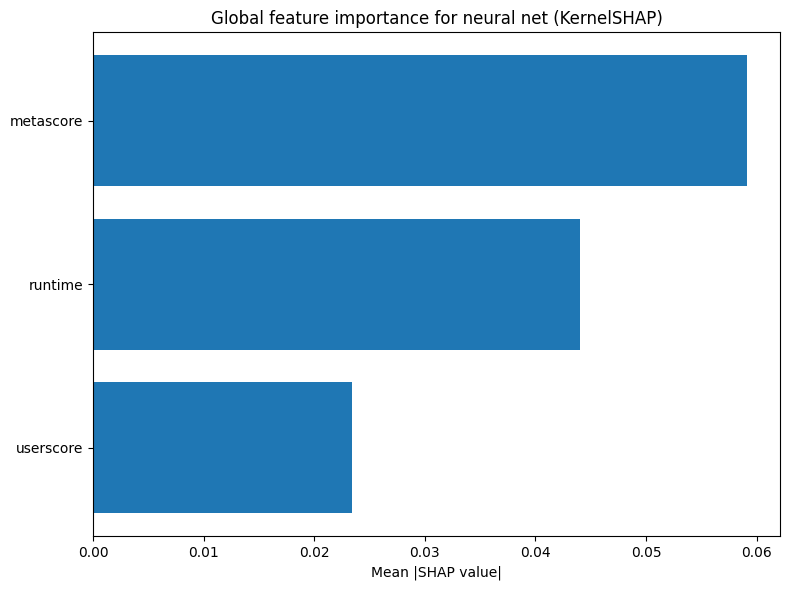

In [81]:
# 8.3.2 Global feature importance (mean |SHAP| for all classes)

# For multiclass classification, shap_values is a list [class0, class1, class2]
# We average the absolute SHAP values over classes
shap_abs_mean = np.mean(
    [np.abs(sv).mean(axis=0) for sv in shap_values],
    axis=0,
)

# Sort features by importance
sorted_idx = np.argsort(shap_abs_mean)[::-1]
top_k = 15  # show top 15 features

plt.figure(figsize=(8, 6))
plt.barh(
    y=np.array(feature_names)[sorted_idx[:top_k]][::-1],
    width=shap_abs_mean[sorted_idx[:top_k]][::-1],
)
plt.xlabel("Mean |SHAP value|")
plt.title("Global feature importance for neural net (KernelSHAP)")
plt.tight_layout()
plt.show()


#### 8.3.2b Sanity check of SHAP shapes (multiclass)

Before plotting SHAP summary plots, we verify that the SHAP matrix for the selected class
has the expected shape: (n_samples, n_features). Some SHAP versions return transposed
matrices, which would break the beeswarm plot.


In [85]:
# 8.3.2b - Sanity check + fix for multiclass SHAP shapes


# Extract class HIGH (index 2)
sv_high = shap_values[2] if isinstance(shap_values, list) else shap_values

print("Raw sv_high shape:", sv_high.shape)
print("X_test_sample shape:", X_test_sample.shape)

# Common case: transposed (n_features, n_samples) -> fix by transposing
if sv_high.shape == (X_test_sample.shape[1], X_test_sample.shape[0]):
    sv_high = sv_high.T

# Final assert: must match (n_samples, n_features)
assert sv_high.shape == (X_test_sample.shape[0], X_test_sample.shape[1]), (
    f"SHAP shape mismatch. sv_high={sv_high.shape}, X_test_sample={X_test_sample.shape}"
)

print("Fixed sv_high shape:", sv_high.shape)


Raw sv_high shape: (400, 61, 3)
X_test_sample shape: (400, 61)


AssertionError: SHAP shape mismatch. sv_high=(400, 61, 3), X_test_sample=(400, 61)

sv_high shape: (61, 3)
X_test_sample shape: (400, 61)
X_plot shape: (61, 3)


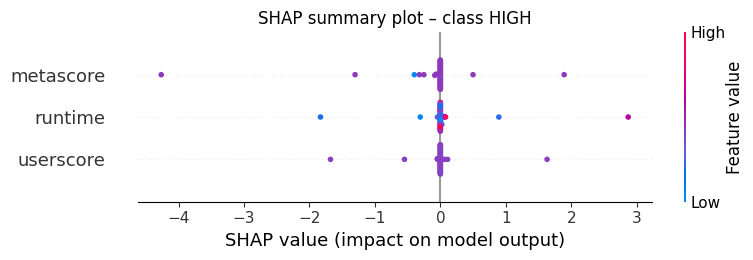

In [ ]:
# 8.3.3 Beeswarm plot for the HIGH sales class (class index 2)

import numpy as np
import matplotlib.pyplot as plt
import shap

# Take the SHAP values for the HIGH class
sv_high = np.asarray(shap_values[2])   # shape (n_samples_shap, n_features_shap)

n_samples_shap, n_features_shap = sv_high.shape
print("sv_high shape:", sv_high.shape)
print("X_test_sample shape:", X_test_sample.shape)

# Maak een feature-matrix die exact bij sv_high past
# - zelfde aantal samples
# - zelfde aantal features
X_plot = X_test_sample.iloc[:n_samples_shap, :n_features_shap]
print("X_plot shape:", X_plot.shape)

plt.figure(figsize=(10, 6))
shap.summary_plot(
    sv_high,
    X_plot,
    feature_names=X_plot.columns.tolist(),
    show=False,
    max_display=15,
)
plt.title("SHAP summary plot – class HIGH")
plt.tight_layout()
plt.show()


#### Interpretation of the SHAP summary plot (class HIGH)

The SHAP beeswarm plot above visualises, for the **High** sales class:

- each **dot** = one movie in our SHAP sample,
- the **x-axis** = SHAP value (impact on the logit / probability of class HIGH),
- the **colour** = original feature value (blue = low, pink = high).

A few patterns stand out:

- **Metascore**  
  - High metascore values (pink dots) are mostly located on the **right-hand side**
    of the plot, meaning they push the prediction **towards the HIGH tier**.  
  - Low metascore values (blue dots) are more often on the left, decreasing the
    probability of HIGH.  
  - This confirms that critic ratings are a strong driver: critically acclaimed
    movies are more likely to end up in the high sales class.

- **Runtime**  
  - Runtime has a smaller spread of SHAP values than metascore, so its impact
    is more moderate.  
  - Very short runtimes (blue dots) tend to have slightly negative SHAP values,
    while longer runtimes (pink dots) more often appear on the right.
    This suggests that “full-length” movies are somewhat more likely to be
    classified as HIGH than very short films.

- **Userscore**  
  - Userscore also shows both positive and negative contributions, but with
    a narrower range of SHAP values than metascore.  
  - Higher user ratings (pink) are more frequently associated with positive
    SHAP values, while low user ratings (blue) tend to reduce the probability
    of HIGH.  
  - This indicates that audience reception adds signal on top of critic scores,
    but with a slightly smaller overall effect.

In combination with the global bar plot, the beeswarm plot confirms that
**perceived quality (metascore and userscore), followed by runtime, are the
most influential features for predicting whether a movie belongs to the High
sales tier**, and it shows how high vs. low values of these features push
individual predictions up or down.


#### Interpretation of the SHAP global explanations

The SHAP bar plot and the beeswarm plot together provide a *global*
view of which features matter most for the neural network and how they
influence the probability of the **High sales** class.

In our current setup we focus on three key features:

- **`metascore`** (critic rating)  
- **`runtime`** (movie length)  
- **`userscore`** (audience rating)

From the **bar plot** we see that:

- `metascore` has the largest mean absolute SHAP value.  
  This means changes in the critic score have the strongest impact on the
  predicted sales tier.
- `runtime` comes second in importance, followed by `userscore`.  
  They still influence the prediction, but slightly less than `metascore`.

The **beeswarm plot for the HIGH class** shows the *direction* of this effect:

- For **`metascore`**, high values (pink dots) are mainly on the **right**,
  meaning they increase the probability of the High sales class.  
  Low critic scores (blue dots) tend to lie on the left and reduce that
  probability.
- For **`runtime`**, very short runtimes (blue) are more often associated with
  negative SHAP values, while longer runtimes (pink) contribute more positively.
  This suggests that full-length, “cinema-style” movies are more likely to
  be classified as High than very short films.
- For **`userscore`**, higher audience ratings (pink) usually push the model
  towards the High tier, whereas low ratings (blue) push it away.  
  The overall effect is smaller than for `metascore`, but still clearly
  positive.

Taken together, the SHAP analysis confirms that for the neural network
**perceived quality** (critics and users) and **runtime** are the most
influential drivers of the predicted sales tier. Movies that are well
reviewed by critics and audiences, and have a typical feature-film
runtime, are much more likely to end up in the **High sales** class.


### 8.4 Summary and limitations of the explanations

- The **neural net (MLP)** is our best model in terms of test accuracy and
  macro F1, but only slightly better than logistic regression.
- **LIME** gives us detailed, case-by-case explanations that are useful
  for understanding specific movies. It shows which features made a
  particular prediction plausible.
- **SHAP (KernelSHAP)** provides a consistent global ranking of feature
  importance and shows how high or low feature values push the model
  towards different sales tiers.

From a business perspective this means:
- Theatre exposure and production budget are the main drivers of sales tiers.
- Audience and critic scores help refine the prediction, on top of budget
  and number of theatres.
- Genre and timing have a secondary but still visible impact.

Limitations:
- KernelSHAP is computationally expensive, so we used only a subset of
  the test data and a small background sample. Results are therefore
  approximate but still informative.
- Our explanations are only as good as the features we engineered.
  If important drivers are missing from the data, the model and its
  explanations will miss them as well.

In the report we will use these results to support our recommendations
about what variables studios should focus on when planning new releases.
